# Particle Swarm Optimization (PSO)

## Import libraries

In [28]:
# Some libraries
from matplotlib.pyplot import semilogy
from functools import *
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
import benchmarks

In [29]:
PLOTS_DIR_PATH = "/content/gdrive/Shareddrives/• ING3 (2022-23) /Optimisation Métaheuristique/1. Optimisation stochastique multi-agents (DE, PSO, ABC)/TDs/td1 - plot results"

## Initialization

### Parameters

![alt text](images/parameter_tuning.png)

- PSI : Permet de définir la capacité de l'essaim à changer de direction. Les particules ont une inertie proportionnelle à ce coefficient (l'inertie d'un corps est sa tendance à conserver sa vitesse)

- the $c_1$ hyperparameter allows defining the ability of the group to be influenced by the **best personal solutions** found over the iterations.
- The hyperparameter $c_2$  allows defining the ability of the group to be influenced by the **best global solution** found over the iterations.

Function to optimize :  mccormick
Dimension :  2
Search space :  [-1.5, -1.5] [4, 4]


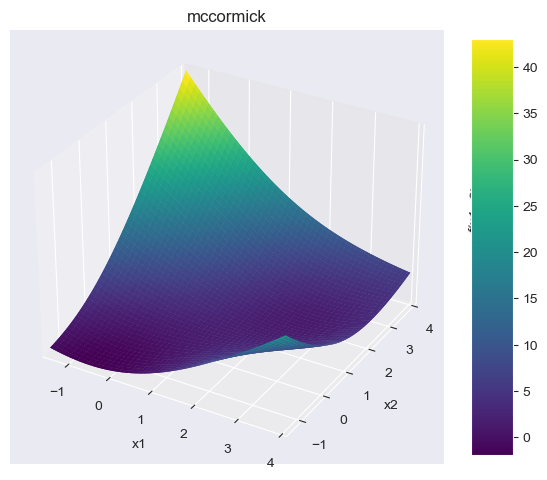

In [30]:

# Evaluation function
FUNCTION = benchmarks.mccormick # function to optimize

DIM = 2  # problem dimension
# domain of variation definition
INFS, SUPS = benchmarks.get_domain_by_function_name(FUNCTION.__name__,DIM)  # search space

print("Function to optimize : ", FUNCTION.__name__)
print("Dimension : ", DIM)
print("Search space : ", INFS, SUPS)

def viz_3D_function(func, infs, sups, title=""):
    """
    Plot the function in the search space.
    """
    # square figure
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')
    # plot function
    x = np.linspace(infs[0], sups[0], 100)
    y = np.linspace(infs[1], sups[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([func(np.array([X[i, j], Y[i, j]])) for i in range(X.shape[0]) for j in range(X.shape[1])]).reshape(
        X.shape)

    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    # add range bar on the right
    fig.colorbar(ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none'), ax=ax, shrink=0.9, aspect=10)
    # Plot the swarm (top view)
    ax.set_xlim(infs[0], sups[0])
    ax.set_ylim(infs[1], sups[1])
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("f(x1,x2)")
    ax.set_title(title)
    # hide z axis
    ax.set_zticks([])
    plt.show()

viz_3D_function(FUNCTION, INFS, SUPS, title=FUNCTION.__name__)

In [31]:
ITER_MAX = 300  # maximum number of iterations
N_PARTICLES = int(10 + 2 * np.sqrt(DIM))  # number of particles in the swarm

# psi,cmax = (0.8, 1.62)
# psi,cmax = (0.7, 1.47)
PSI = 0.7
C1 = C2 = CMAX = 1.62

if C1 + C2 > 4:
    raise ValueError("C1 + C2 must be inferior to 4")
PSI, C1, C2

(0.7, 1.62, 1.62)

### Particle
create a particle
one particle is discribed by :
- pos : solution list of variables
- vit : movement velocity (null at the initialization)
- fit :  fitness of the solution
- bestpos : best visited position
- bestfit : evaluation of the best visited solution
- bestvois : best neighbor (global for this version)

In [32]:
def init_one(dim: int, inf: list, sup: list, eval_func=FUNCTION):
    """
    Return a particle with random position and null velocity.
    bestpos and bestfit refer to the best position and fitness found by the particle itself.
    bestvois refers to the best particle's neighbors.
    """
    pos = np.array([np.random.uniform(inf[i], sup[i]) for i in range(dim)])
    fit = eval_func(pos)  # evaluation of the solution
    return {'vit': np.zeros(dim), 'pos': pos, 'fit': fit, 'bestpos': pos[:], 'bestfit': fit, 'bestvois': None}


init_one(DIM, INFS, SUPS)

{'vit': array([0., 0.]),
 'pos': array([-1.48864319,  1.13169063]),
 'fit': 12.578920178799049,
 'bestpos': array([-1.48864319,  1.13169063]),
 'bestfit': 12.578920178799049,
 'bestvois': None}

### Population (swarm)

In [33]:
# Init of the population (swarm)
def init_swarm(n, dim: int, inf: list, sup: list):
    return [init_one(dim, inf, sup) for _ in range(n)]


swarm_test = init_swarm(N_PARTICLES, DIM, INFS, SUPS)
swarm_test

[{'vit': array([0., 0.]),
  'pos': array([2.1502524 , 0.94644077]),
  'fit': 1.6347701694756973,
  'bestpos': array([2.1502524 , 0.94644077]),
  'bestfit': 1.6347701694756973,
  'bestvois': None},
 {'vit': array([0., 0.]),
  'pos': array([-1.30745413,  0.64165062]),
  'fit': 7.746625887795425,
  'bestpos': array([-1.30745413,  0.64165062]),
  'bestfit': 7.746625887795425,
  'bestvois': None},
 {'vit': array([0., 0.]),
  'pos': array([3.09133925, 0.77606043]),
  'fit': 2.9999189248040725,
  'bestpos': array([3.09133925, 0.77606043]),
  'bestfit': 2.9999189248040725,
  'bestvois': None},
 {'vit': array([0., 0.]),
  'pos': array([-1.40468024,  2.4845327 ]),
  'fit': 25.326217586446617,
  'bestpos': array([-1.40468024,  2.4845327 ]),
  'bestfit': 25.326217586446617,
  'bestvois': None},
 {'vit': array([0., 0.]),
  'pos': array([ 1.39262725, -1.47783903]),
  'fit': 3.370929492236558,
  'bestpos': array([ 1.39262725, -1.47783903]),
  'bestfit': 3.370929492236558,
  'bestvois': None},
 {'vit'

### Plot the swarm

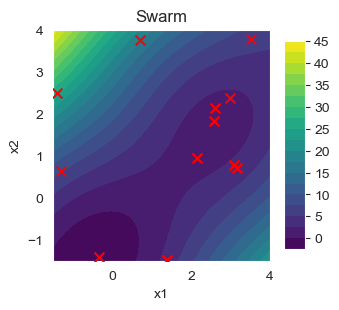

In [34]:
def plot_swarm(swarm: list, dim: int, infs: list, sups: list, eval_func=FUNCTION,
               title: str = "Swarm",coef_figsize=1):
    """
    Plot the swarm in the search space.
    """
    if (dim > 2):
        print("Plotting is only possible for 2D and 3D problems")
        return

    if (dim == 2):
        # square figure
        fig, ax = plt.subplots(figsize=(7*coef_figsize, 6*coef_figsize))
        # plot function
        x = np.linspace(infs[0], sups[0], 100)
        y = np.linspace(infs[1], sups[1], 100)
        X, Y = np.meshgrid(x, y)
        Z = eval_func(np.array([X, Y]))
        ax.contour(X, Y, Z, 20, cmap='viridis', zorder=0)
        # add range bar on the right
        fig.colorbar(ax.contourf(X, Y, Z, 20, cmap='viridis'), ax=ax, shrink=0.9, aspect=10)
        # Plot the swarm (top view)
        ax.set_xlim(infs[0], sups[0])
        ax.set_ylim(infs[1], sups[1])
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_title(title)
        # Plot the swarm
        for particle in swarm:
            ax.scatter(particle["pos"][0], particle["pos"][1], color="red", s=50, zorder=10, marker="x")

    plt.show()


plot_swarm(swarm_test, DIM, INFS, SUPS, coef_figsize=0.5)

In [35]:
def plot_swarm_with_plotly(swarm: list, dim: int, infs: list, sups: list, eval_func=FUNCTION):
    """
    Plot the swarm in the search space.
    """
    if dim > 2:
        print("Plotting is only possible for 1D, 2D problems")
        return

    if dim == 1:
        # plot function
        x = np.linspace(infs[0], sups[0], 100)
        fig = go.Figure(data=[go.Scatter(x=x, y=eval_func(x))])

        # Plot the swarm
        for particle in swarm:
            fig.add_trace(go.Scatter(x=[particle["pos"][0]], y=[particle["pos"][1]], mode='markers',
                                     marker=dict(color='red', size=10)))

        fig.update_layout(
            xaxis=dict(range=[infs[0], sups[0]], autorange=False, zeroline=False),
            yaxis=dict(range=[infs[1], sups[1]], autorange=False, zeroline=False),
            title_text="Swarm")

        fig.show()

    elif dim == 2:
        # plot function
        x = np.linspace(infs[0], sups[0], 100)
        y = np.linspace(infs[1], sups[1], 100)
        X, Y = np.meshgrid(x, y)
        Z = eval_func(np.array([X, Y]))
        fig = go.Figure(data=[go.Contour(z=Z, x=x, y=y, colorscale='Viridis')])

        # Plot the swarm
        for particle in swarm:
            fig.add_trace(go.Scatter(x=[particle["pos"][0]], y=[particle["pos"][1]], mode='markers',
                                     marker=dict(color='red', size=10)))

        fig.update_layout(
            #xaxis=dict(range=[infs[0], sups[0]], autorange=False, zeroline=False),
            #yaxis=dict(range=[infs[1], sups[1]], autorange=False, zeroline=False),
            title_text="Swarm",
            title_x=0.5,
            width=800,
            height=800,
        )

    fig.show()


plot_swarm_with_plotly(swarm_test, DIM, INFS, SUPS)

## Particle Update


In [36]:
# compare two particles and return True if the first one is better than the second one
def is_better(p1, p2):
    return p1["fit"] < p2["fit"]


# Return the particle with the best fitness
def max_particle(p1, p2):
    if is_better(p1, p2):
        return p1
    else:
        return p2


# Returns a copy of the particle with the best fitness in the population
def get_best_particles(swarm):
    return reduce(max_particle, swarm)


get_best_particles(swarm_test)

{'vit': array([0., 0.]),
 'pos': array([-0.3332516 , -1.41693779]),
 'fit': -1.8520434880005388,
 'bestpos': array([-0.3332516 , -1.41693779]),
 'bestfit': -1.8520434880005388,
 'bestvois': None}

In [37]:
# Update information of the particle, add information about the best neighbor
def update_best_info(particle, best_particle):
    particle["bestvois"] = dict(best_particle)
    if (particle["fit"] < particle["bestfit"]):
        particle["bestfit"] = particle["fit"]
        particle["bestpos"] = particle["pos"][:]
    return particle


print(swarm_test[0])
update_best_info(swarm_test[0], get_best_particles(swarm_test))

{'vit': array([0., 0.]), 'pos': array([2.1502524 , 0.94644077]), 'fit': 1.6347701694756973, 'bestpos': array([2.1502524 , 0.94644077]), 'bestfit': 1.6347701694756973, 'bestvois': None}


{'vit': array([0., 0.]),
 'pos': array([2.1502524 , 0.94644077]),
 'fit': 1.6347701694756973,
 'bestpos': array([2.1502524 , 0.94644077]),
 'bestfit': 1.6347701694756973,
 'bestvois': {'vit': array([0., 0.]),
  'pos': array([-0.3332516 , -1.41693779]),
  'fit': -1.8520434880005388,
  'bestpos': array([-0.3332516 , -1.41693779]),
  'bestfit': -1.8520434880005388,
  'bestvois': None}}

In [38]:
# Update information of swarm
def update_best_info_swarm(swarm, best_particle):
    #best_particle = get_best_of_the_swarm(swarm)
    return [update_best_info(particle, best_particle) for particle in swarm]

### Move

![image.png](images/particle_update.png)


In [39]:
# Calculate the velocity and move a particle
def move_particle(particle, psi: float, c1: float, c2: float, infs: list, sups: list,
                  eval_func=FUNCTION):
    rho1 = c1 * np.random.uniform()
    rho2 = c2 * np.random.uniform()

    # Velocity calculation (V_new = psi*V_old + rho1 * (bestpos - pos) + rho2 * (bestvois - pos))
    velocity_new = particle["vit"] * psi + rho1 * (particle["bestpos"] - particle["pos"]) + rho2 * (
            particle["bestvois"]["pos"] - particle["pos"])
    # New position calculation
    position_new = particle["pos"] + velocity_new

    # Bornage : For each dimension, if the particle is out of the search space, we put it back in
    position_new = np.clip(position_new, infs, sups)

    # Evaluation of the new position
    evaluation_new = eval_func(position_new)

    # Update of the particle
    particle["vit"] = velocity_new
    particle["pos"] = position_new
    particle["fit"] = evaluation_new

    return particle


print(swarm_test[0])
move_particle(swarm_test[0], DIM, PSI, CMAX, INFS, SUPS)

{'vit': array([0., 0.]), 'pos': array([2.1502524 , 0.94644077]), 'fit': 1.6347701694756973, 'bestpos': array([2.1502524 , 0.94644077]), 'bestfit': 1.6347701694756973, 'bestvois': {'vit': array([0., 0.]), 'pos': array([-0.3332516 , -1.41693779]), 'fit': -1.8520434880005388, 'bestpos': array([-0.3332516 , -1.41693779]), 'bestfit': -1.8520434880005388, 'bestvois': None}}


{'vit': array([-2.34674957, -2.23323885]),
 'pos': array([-0.19649718, -1.28679808]),
 'fit': -1.7296675984119867,
 'bestpos': array([2.1502524 , 0.94644077]),
 'bestfit': 1.6347701694756973,
 'bestvois': {'vit': array([0., 0.]),
  'pos': array([-0.3332516 , -1.41693779]),
  'fit': -1.8520434880005388,
  'bestpos': array([-0.3332516 , -1.41693779]),
  'bestfit': -1.8520434880005388,
  'bestvois': None}}

In [40]:
def move_swarm(swarm: list, psi: float, c1: float, c2: float, infs: list, sups: list,
               eval_func=FUNCTION):
    return [move_particle(particle, psi, c1, c2, infs, sups, eval_func) for particle in swarm]

## PSO algorithm

### Convergence criteria

Stop the algorithm when the average distance between all particles in the population is less than a threshold.

Pour évaluer à quel point les particules dans votre population sont proches les unes des autres, on va utiliser la distance moyenne entre les positions de toutes les particules dans la population.

In [41]:
def evaluate_cohesion(population: list) -> float:
    """
    Return the average distance between all particles in the population.
    """
    num_particles = len(population)
    total_distance = 0
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            distance = np.linalg.norm(population[i]['pos'] - population[j]['pos'])  # euclidean distance
            total_distance += distance
    avg_distance = total_distance / (num_particles * (num_particles - 1) / 2)
    return avg_distance


evaluate_cohesion(swarm_test)

3.36257050226125

### Plotting functions

In [42]:
def print_solution(best):
    print("  point = {}".format(best['pos']))
    print("  eval = {}".format(best['fit']))


def plot_history(h_best_particle, h_cohesion, title=""):
    # Plot the evolution of the best fit and cohesion (subplots)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title)
    ax1.plot([h_best_particle[i]['fit'] for i in range(len(h_best_particle))], color='green')
    ax1.set_title('Evolution of the best fit')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Best fit')

    ax2.plot(h_cohesion, color='orange')
    ax2.set_title('Evolution of the cohesion')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Cohesion')

    plt.show()


def plot_history_swarm(history_swarm: list, dim: int, infs: list, sups: list,
                       eval_func=FUNCTION,
                       title: str = "Swarm History", n_subplots: int = 5):
    if (dim > 2):
        print("Plotting is only possible for 2D and 3D problems")
        return

    if (dim == 2):
        len_history = len(history_swarm)
        step = len_history // n_subplots if len_history > n_subplots else 1
        indexes = list(range(0, len_history, step))
        indexes = indexes + [len_history - 1] if indexes[-1] != len_history - 1 else indexes
        indexes = indexes[:-2] + [indexes[-1]] if len(indexes) > n_subplots else indexes
        swarm_to_plot = [history_swarm[k] for k in indexes]
        # make n subplots
        fig = plt.figure(figsize=(14, int(6 * n_subplots / 3)))
        fig.suptitle(title, fontsize=16)
        for i, swarm in enumerate(swarm_to_plot, start=0):
            # plot function
            ax = fig.add_subplot(n_subplots, 3, i + 1)
            x = np.linspace(infs[0], sups[0], 100)
            y = np.linspace(infs[1], sups[1], 100)
            X, Y = np.meshgrid(x, y)
            Z = eval_func(np.array([X, Y]))
            ax.contour(X, Y, Z, 20, cmap='viridis', zorder=0)
            # add range bar on the right
            fig.colorbar(ax.contourf(X, Y, Z, 20, cmap='viridis'), ax=ax, shrink=0.9, aspect=10)
            # Plot the swarm (top view)
            ax.set_xlim(infs[0], sups[0])
            ax.set_ylim(infs[1], sups[1])
            ax.set_xlabel("x1")
            ax.set_ylabel("x2")
            ax.set_title(" - iteration " + str(indexes[i]))
            # Plot the swarm
            for particle in swarm:
                ax.scatter(particle["pos"][0], particle["pos"][1], color="red", s=50, zorder=10, marker="x")
    fig.tight_layout()
    plt.show()

### Main algorithm

>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 12
 * iter_max = 300
 * dim = 2
 * eval_func = mccormick
 * psi = 0.7
 * c1 = 1.62
 * c2 = 1.62
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 15


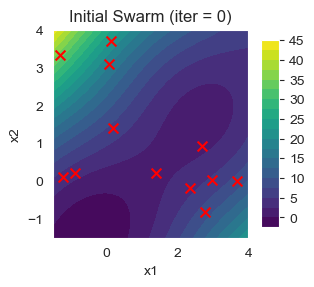

  0%|          | 0/300 [00:00<?, ?it/s]

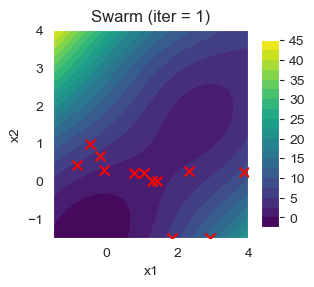

  1%|          | 2/300 [00:00<02:03,  2.41it/s]

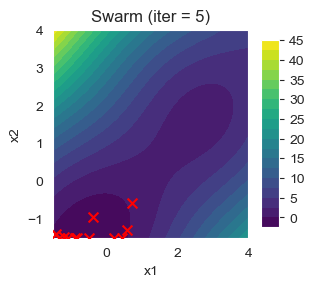

  2%|▏         | 6/300 [00:01<01:29,  3.27it/s]

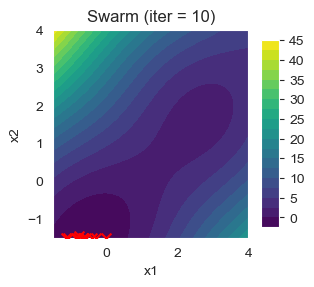

  4%|▎         | 11/300 [00:02<01:08,  4.24it/s]

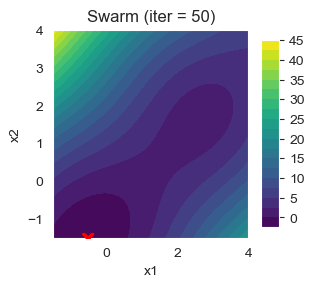

 17%|█▋        | 51/300 [00:03<00:10, 23.42it/s]

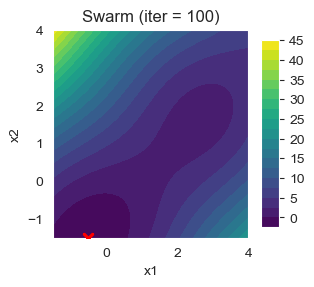

 49%|████▉     | 147/300 [00:03<00:04, 38.22it/s]


>>> Break : cohesion < epsilon=1e-06


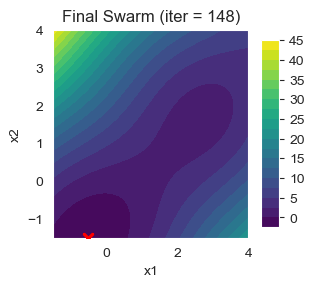

History size :  149
>>> Results after 147 iterations :
> Best solution since the beginning :
  point = [-0.52888339 -1.5       ]
  eval = -1.9105075469843982
> Best solution at the end :
  point = [-0.52888339 -1.5       ]
  eval = -1.9105075469843982
>>> Display history :


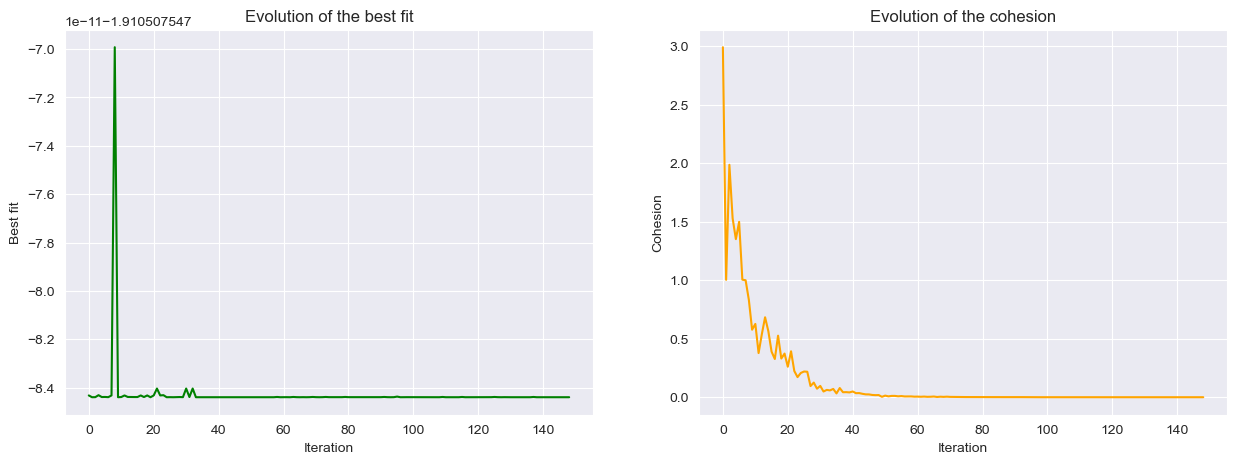

In [43]:
def pso_algorithm_continu(n_particles: int, iter_max: int, dim: int, infs: list, sups: list,
                          eval_func, psi: float = PSI, c1: float = C1, c2: float = C2,
                          verbose: bool = True, display_history: bool = True, display_swarm_plots=True,
                          iter_swarm_plots: list = [],
                          epsilon_coherence: float = 1e-06, max_iter_no_improvement: int = 15):
    if verbose:
        print(">>> Start PSO algorithm")
        print(">>> Parameters :")
        print(f" * n_particles = {n_particles}")
        print(f" * iter_max = {iter_max}")
        print(f" * dim = {dim}")
        print(f" * eval_func = {eval_func.__name__}")
        print(f" * psi = {psi}")
        print(f" * c1 = {c1}")
        print(f" * c2 = {c2}")
        print(f" * epsilon_coherence = {epsilon_coherence}")
        print(f" * max_iter_no_improvement = {max_iter_no_improvement}")

    # initialization of the population
    swarm = init_swarm(n_particles, dim, infs, sups)
    plot_swarm(swarm, dim, infs, sups, title=f"Initial Swarm (iter = 0)",coef_figsize=0.45) if display_swarm_plots else None
    # initialization of the best solution
    best_of_the_swarm = get_best_particles(swarm)
    history_best_particle = [best_of_the_swarm]
    history_cohesion = [evaluate_cohesion(swarm)]
    history_swarm = [swarm[:]]
    iter_no_improvement = 0
    count_improvement = 0
    if verbose:
        range_iter = tqdm(range(iter_max))
    else:
        range_iter = range(iter_max)
    for i in range_iter:
        # update informations
        swarm = update_best_info_swarm(swarm, best_of_the_swarm)  # tout le monde enregeristre la position du plus beau
        # velocity calculations and displacement

        swarm = move_swarm(swarm, psi, c1, c2, infs, sups, eval_func)
        plot_swarm(swarm, dim, infs, sups,
                   title=f"Swarm (iter = {i})",coef_figsize=0.45) if display_swarm_plots and i in iter_swarm_plots else None

        # update of the best solution
        best_of_the_swarm = get_best_particles(swarm)

        # historization of data
        history_best_particle.append(best_of_the_swarm)  # historisation de la meilleure particule
        history_cohesion.append(evaluate_cohesion(swarm))  # historisation de la cohesion
        history_swarm.append(swarm[:])  # historisation de l'etat de la population

        # check if the swarm is too coherent
        if history_cohesion[-1] < epsilon_coherence:
            if verbose:
                print(f">>> Break : cohesion < epsilon={epsilon_coherence}")
            break

        # check if no improvement since a while
        if not is_better(history_best_particle[-1], history_best_particle[-2]):
            iter_no_improvement += 1
            #print(f">>> No improvement since {iter_no_improvement} iterations")
            if iter_no_improvement >= max_iter_no_improvement:
                if verbose:
                    print(f">>> Break : no improvement since {max_iter_no_improvement} iterations")
                break
        else:
            iter_no_improvement = 0
            count_improvement += 1

    plot_swarm(swarm, dim, infs, sups, title=f"Final Swarm (iter = {i + 1})",coef_figsize=0.45) if display_swarm_plots else None
    # get the best solution since the beginning
    best_since_beginning = get_best_particles(history_best_particle)
    best_at_end = get_best_particles(swarm)
    # displaying result
    if verbose:
        print("History size : ", len(history_best_particle))
        print(">>> Results after", i, "iterations :")

        print("> Best solution since the beginning :")
        print_solution(best_since_beginning)
        print("> Best solution at the end :")
        print_solution(best_at_end)

    # display history
    if display_history:
        print(">>> Display history :")
        plot_history(history_best_particle, history_cohesion)

    return best_since_beginning, best_at_end, history_best_particle, history_cohesion, history_swarm


best_since_beginning, _, _, _, _ = pso_algorithm_continu(
    n_particles=N_PARTICLES, iter_max=ITER_MAX,
    dim=DIM, infs=INFS, sups=SUPS,
    eval_func=FUNCTION,
    psi=PSI, c1=C1, c2=C2, iter_swarm_plots=[1, 5, 10, 50, 100], max_iter_no_improvement=15)

## Multiple execution


### with different parameters

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 12
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.1
 * c1 = 0.25
 * c2 = 2
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


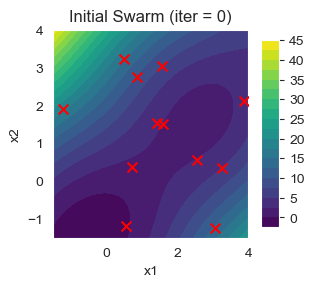

  0%|          | 0/100 [00:00<?, ?it/s]

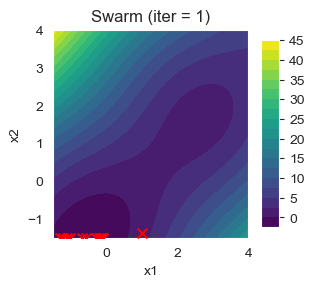

  2%|▏         | 2/100 [00:00<00:20,  4.82it/s]

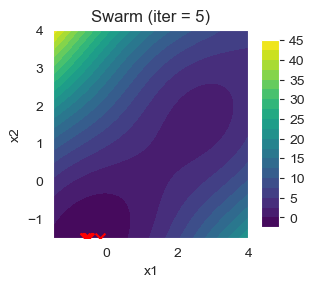

  6%|▌         | 6/100 [00:00<00:12,  7.60it/s]

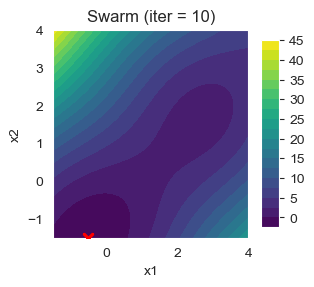

 22%|██▏       | 22/100 [00:01<00:04, 16.31it/s]


>>> Break : cohesion < epsilon=1e-06


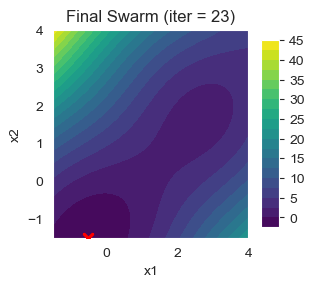

History size :  24
>>> Results after 22 iterations :
> Best solution since the beginning :
  point = [-0.5288834 -1.5      ]
  eval = -1.9105075469843982
> Best solution at the end :
  point = [-0.5288834 -1.5      ]
  eval = -1.9105075469843982
>>> Display history :


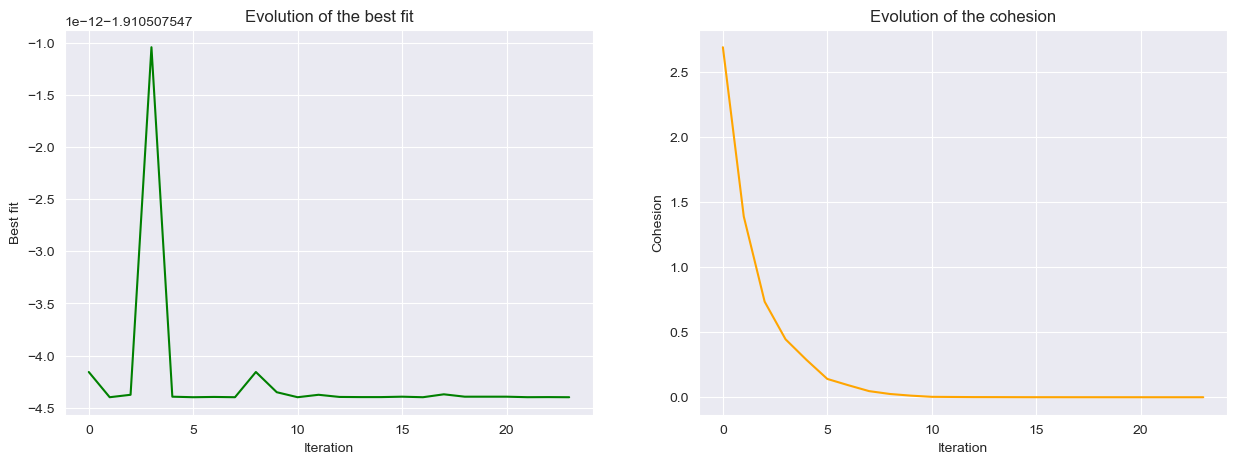

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 50
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.1
 * c1 = 0.25
 * c2 = 2
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


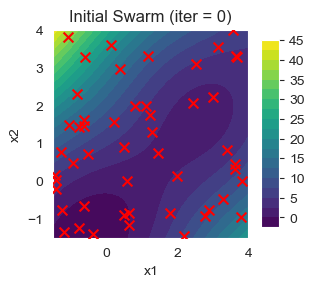

  0%|          | 0/100 [00:00<?, ?it/s]

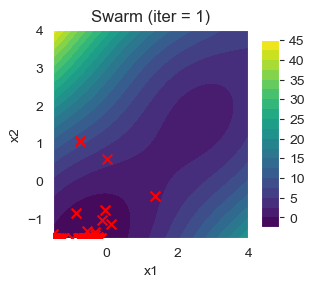

  2%|▏         | 2/100 [00:00<00:27,  3.51it/s]

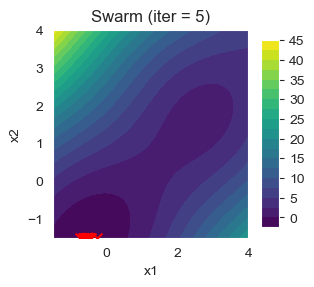

  6%|▌         | 6/100 [00:01<00:20,  4.62it/s]

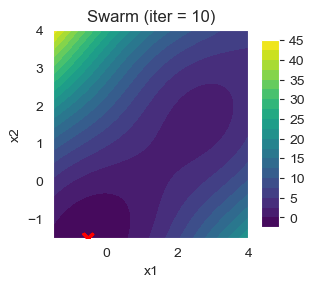

 25%|██▌       | 25/100 [00:02<00:06, 11.13it/s]


>>> Break : cohesion < epsilon=1e-06


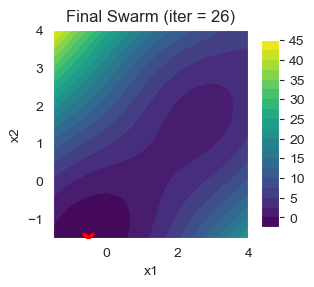

History size :  27
>>> Results after 25 iterations :
> Best solution since the beginning :
  point = [-0.52888339 -1.5       ]
  eval = -1.9105075469843982
> Best solution at the end :
  point = [-0.52888339 -1.5       ]
  eval = -1.9105075469843982
>>> Display history :


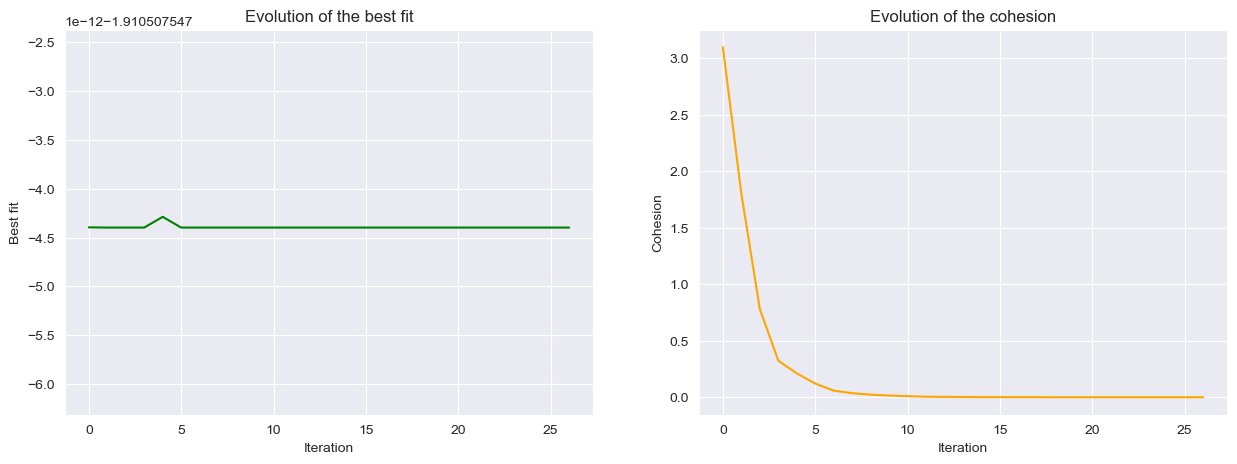

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 12
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.5
 * c1 = 0.25
 * c2 = 2
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


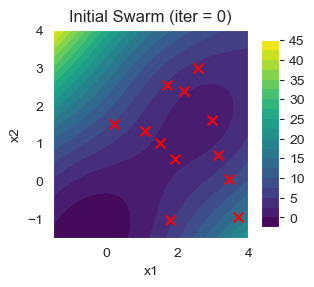

  0%|          | 0/100 [00:00<?, ?it/s]

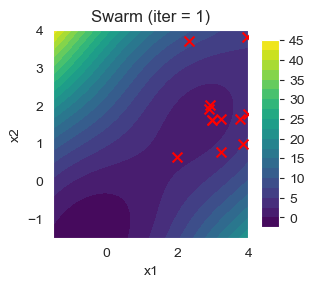

  2%|▏         | 2/100 [00:00<00:21,  4.65it/s]

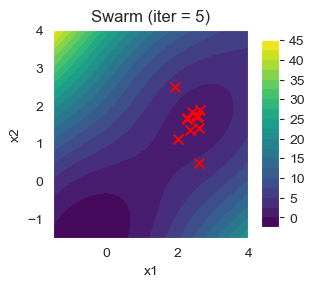

  6%|▌         | 6/100 [00:00<00:12,  7.48it/s]

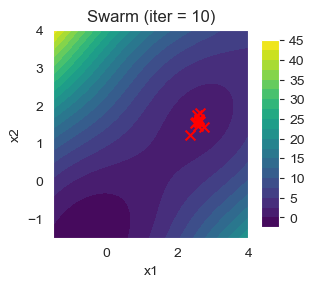

 11%|█         | 11/100 [00:01<00:09,  9.60it/s]

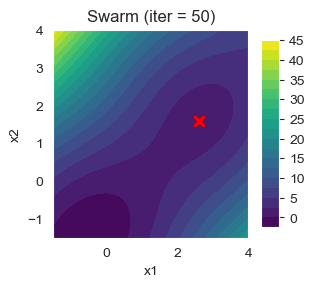

 60%|██████    | 60/100 [00:01<00:01, 34.88it/s]


>>> Break : cohesion < epsilon=1e-06


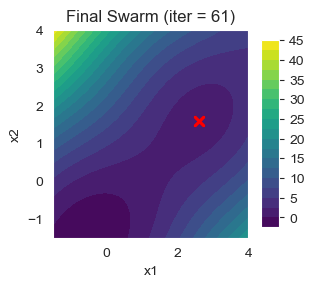

History size :  62
>>> Results after 60 iterations :
> Best solution since the beginning :
  point = [2.594395   1.59439514]
  eval = 1.2283696986087795
> Best solution at the end :
  point = [2.594395   1.59439514]
  eval = 1.2283696986087795
>>> Display history :


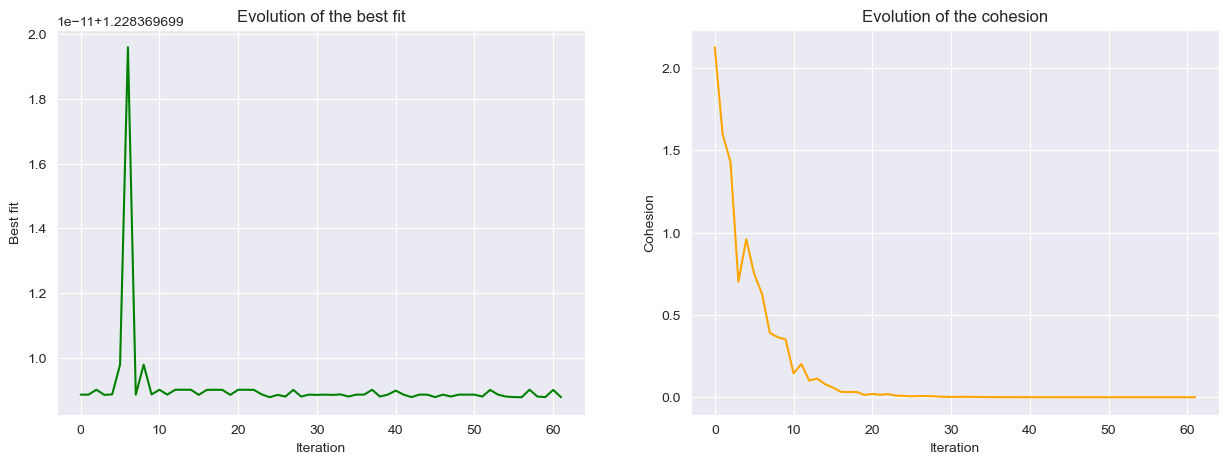

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 50
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.5
 * c1 = 0.25
 * c2 = 2
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


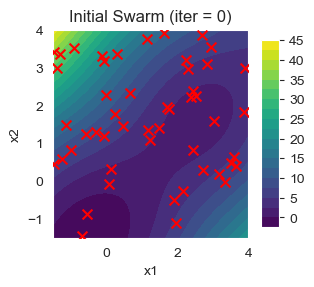

  0%|          | 0/100 [00:00<?, ?it/s]

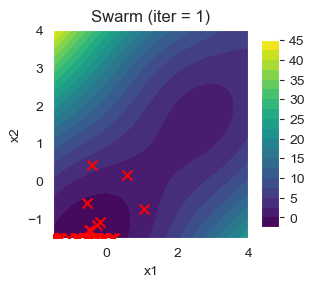

  2%|▏         | 2/100 [00:00<00:25,  3.89it/s]

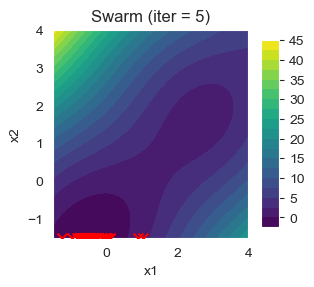

  6%|▌         | 6/100 [00:01<00:14,  6.30it/s]

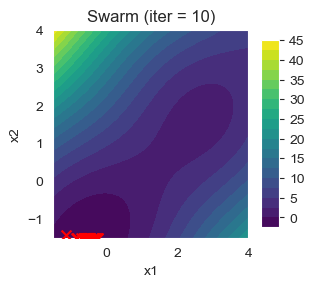

 42%|████▏     | 42/100 [00:01<00:01, 41.66it/s]

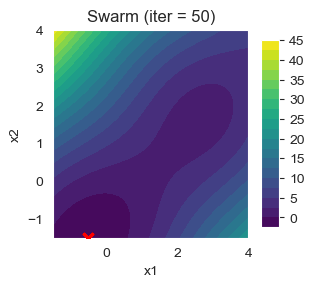

 58%|█████▊    | 58/100 [00:02<00:01, 23.50it/s]


>>> Break : no improvement since 10 iterations


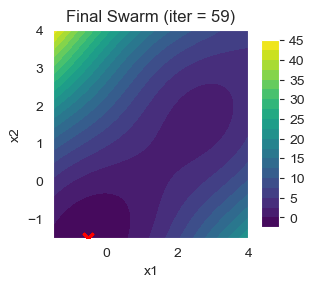

History size :  60
>>> Results after 58 iterations :
> Best solution since the beginning :
  point = [-0.52888339 -1.5       ]
  eval = -1.9105075469843982
> Best solution at the end :
  point = [-0.52888339 -1.5       ]
  eval = -1.9105075469843982
>>> Display history :


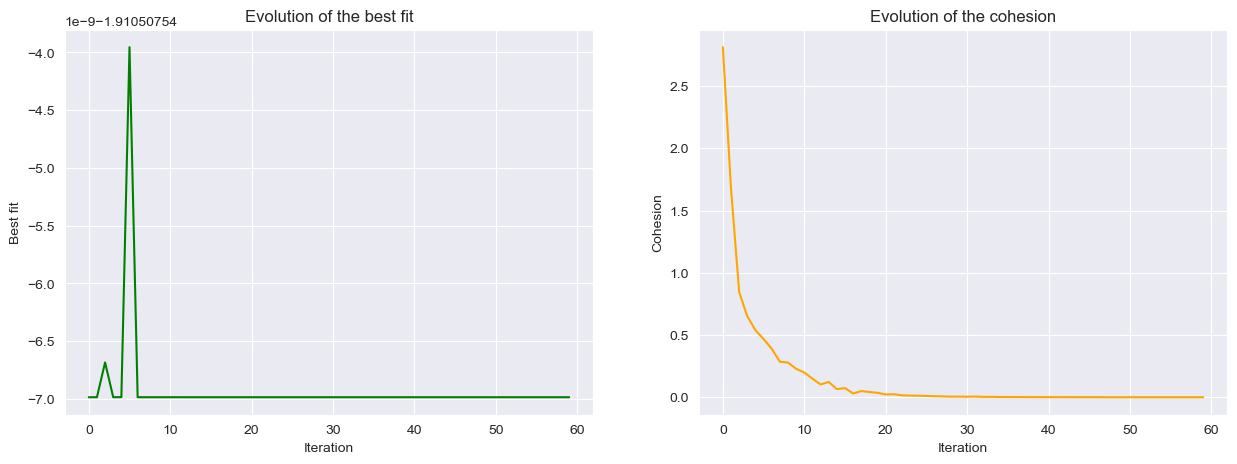

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 12
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.9
 * c1 = 0.25
 * c2 = 2
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


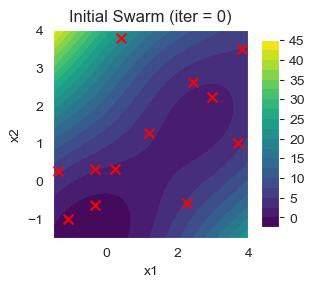

  0%|          | 0/100 [00:00<?, ?it/s]

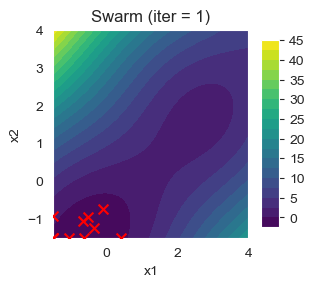

  2%|▏         | 2/100 [00:00<00:30,  3.24it/s]

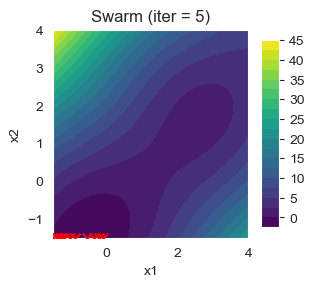

  6%|▌         | 6/100 [00:01<00:14,  6.52it/s]

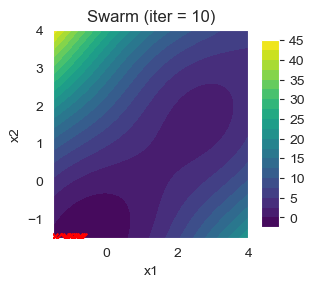

 11%|█         | 11/100 [00:01<00:09,  8.92it/s]

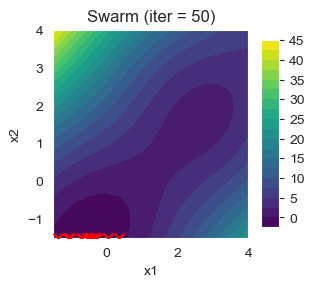

100%|██████████| 100/100 [00:01<00:00, 52.32it/s]


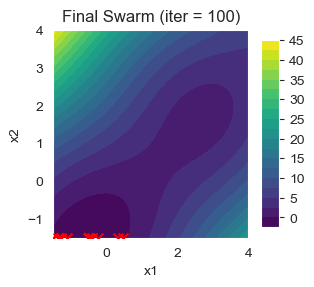

History size :  101
>>> Results after 99 iterations :
> Best solution since the beginning :
  point = [-0.52577149 -1.5       ]
  eval = -1.9104935180592548
> Best solution at the end :
  point = [-0.52577149 -1.5       ]
  eval = -1.9104935180592548
>>> Display history :


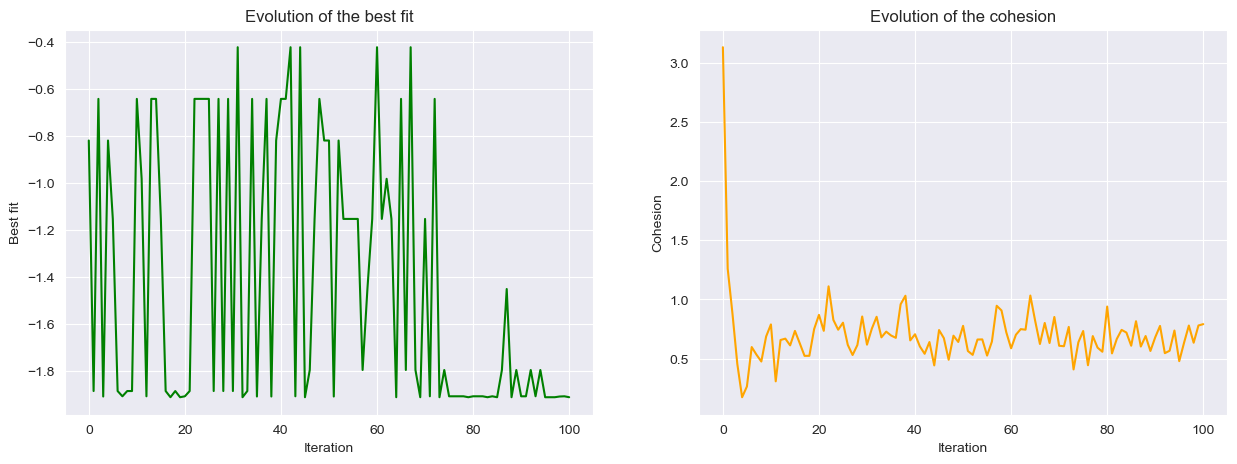

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 50
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.9
 * c1 = 0.25
 * c2 = 2
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


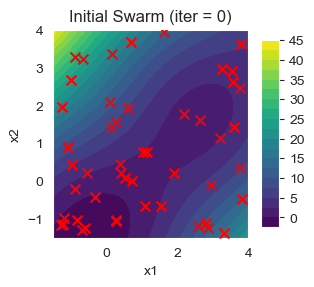

  0%|          | 0/100 [00:00<?, ?it/s]

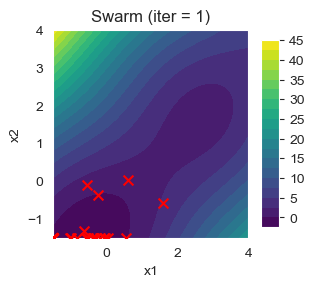

  2%|▏         | 2/100 [00:00<00:24,  3.92it/s]

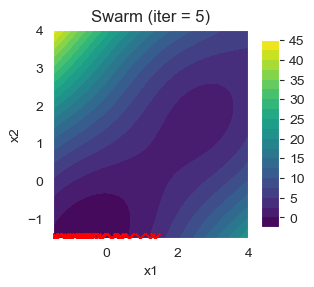

  6%|▌         | 6/100 [00:01<00:15,  6.15it/s]

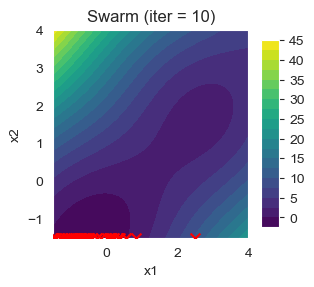

 42%|████▏     | 42/100 [00:02<00:01, 36.70it/s]

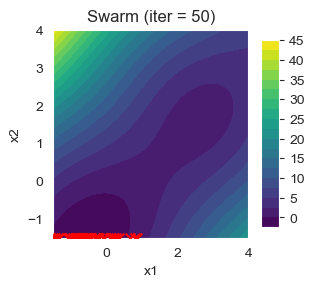

100%|██████████| 100/100 [00:03<00:00, 31.96it/s]


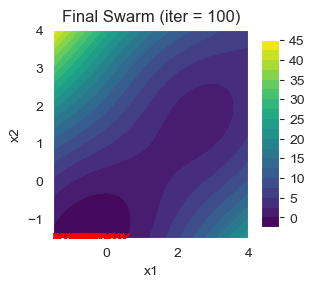

History size :  101
>>> Results after 99 iterations :
> Best solution since the beginning :
  point = [-0.52791677 -1.5       ]
  eval = -1.9105061935407317
> Best solution at the end :
  point = [-0.52791677 -1.5       ]
  eval = -1.9105061935407317
>>> Display history :


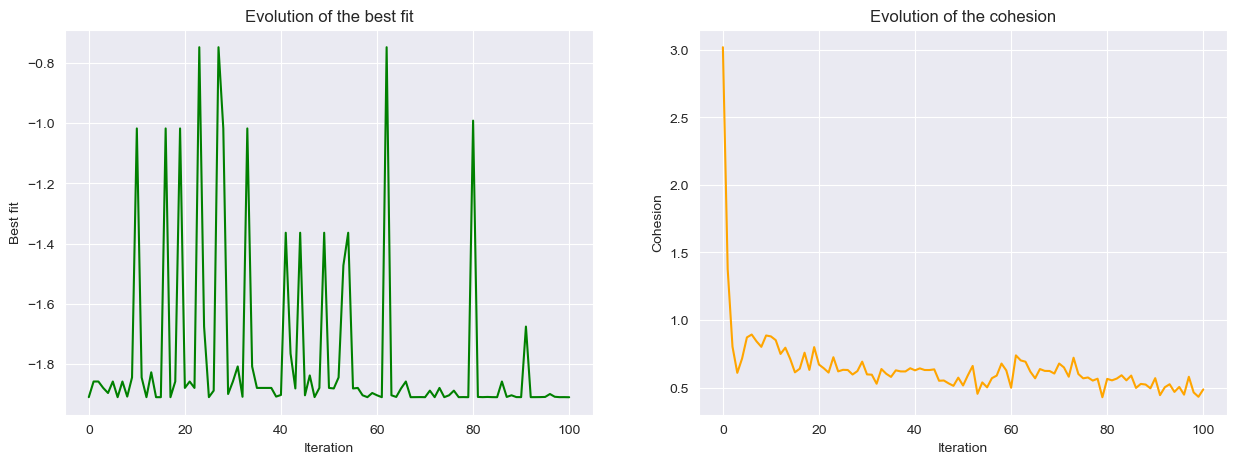

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 12
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.1
 * c1 = 2
 * c2 = 0.25
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


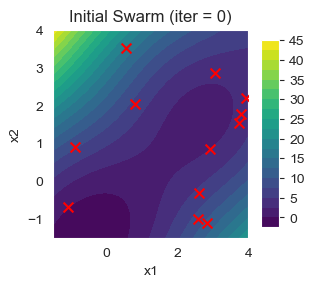

  0%|          | 0/100 [00:00<?, ?it/s]

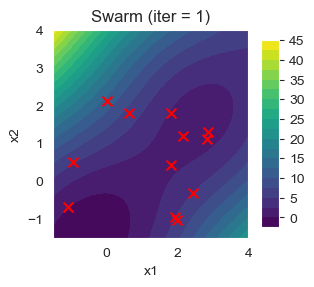

  2%|▏         | 2/100 [00:00<00:21,  4.47it/s]

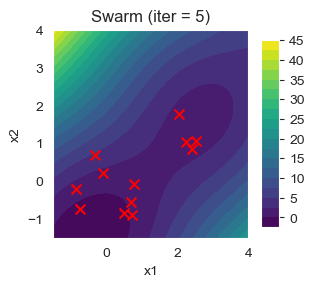

  6%|▌         | 6/100 [00:00<00:12,  7.37it/s]

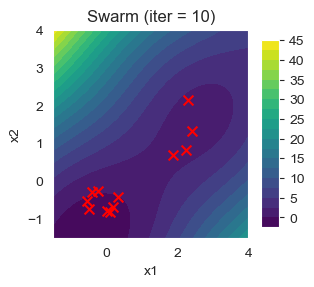

 11%|█         | 11/100 [00:01<00:09,  9.45it/s]

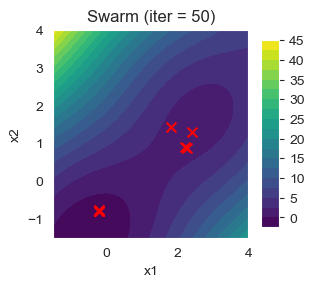

100%|██████████| 100/100 [00:01<00:00, 56.40it/s]


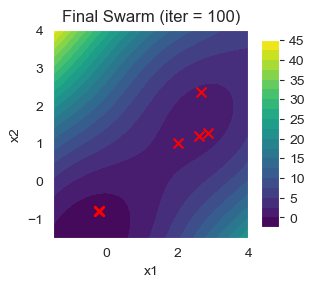

History size :  101
>>> Results after 99 iterations :
> Best solution since the beginning :
  point = [-0.20597161 -0.78082444]
  eval = -1.146911628388656
> Best solution at the end :
  point = [-0.20597161 -0.78082444]
  eval = -1.146911628388656
>>> Display history :


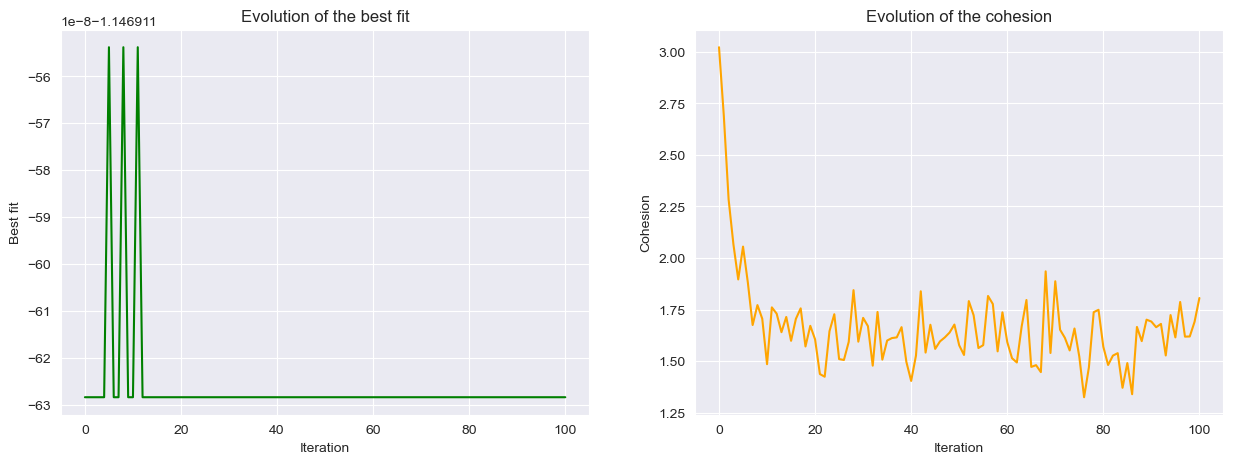

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 50
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.1
 * c1 = 2
 * c2 = 0.25
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


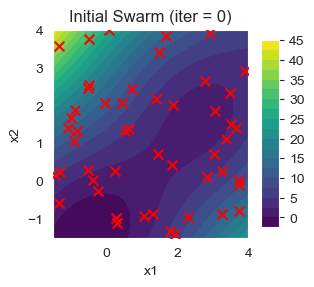

  0%|          | 0/100 [00:00<?, ?it/s]

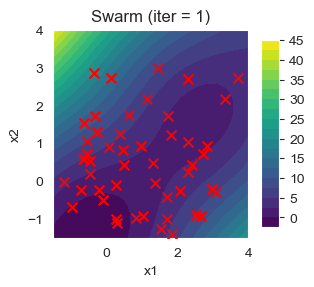

  2%|▏         | 2/100 [00:00<00:24,  3.96it/s]

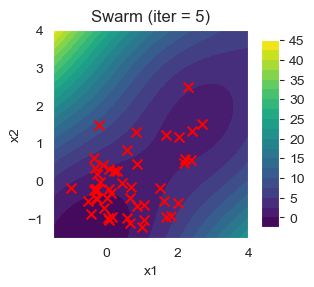

  6%|▌         | 6/100 [00:01<00:15,  6.16it/s]

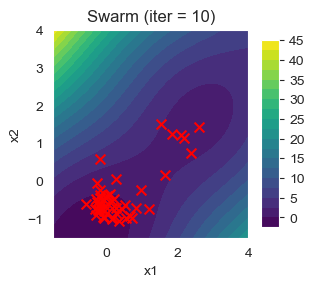

 43%|████▎     | 43/100 [00:01<00:01, 42.59it/s]

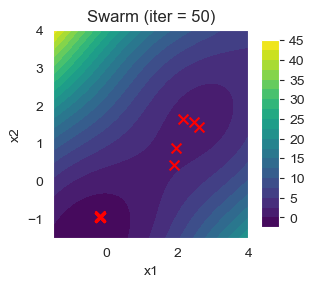

100%|██████████| 100/100 [00:02<00:00, 33.98it/s]


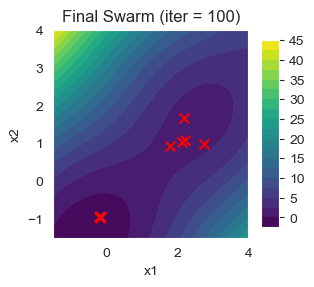

History size :  101
>>> Results after 99 iterations :
> Best solution since the beginning :
  point = [-0.18231373 -0.94093351]
  eval = -1.404869673387227
> Best solution at the end :
  point = [-0.18231373 -0.94093351]
  eval = -1.404869673387227
>>> Display history :


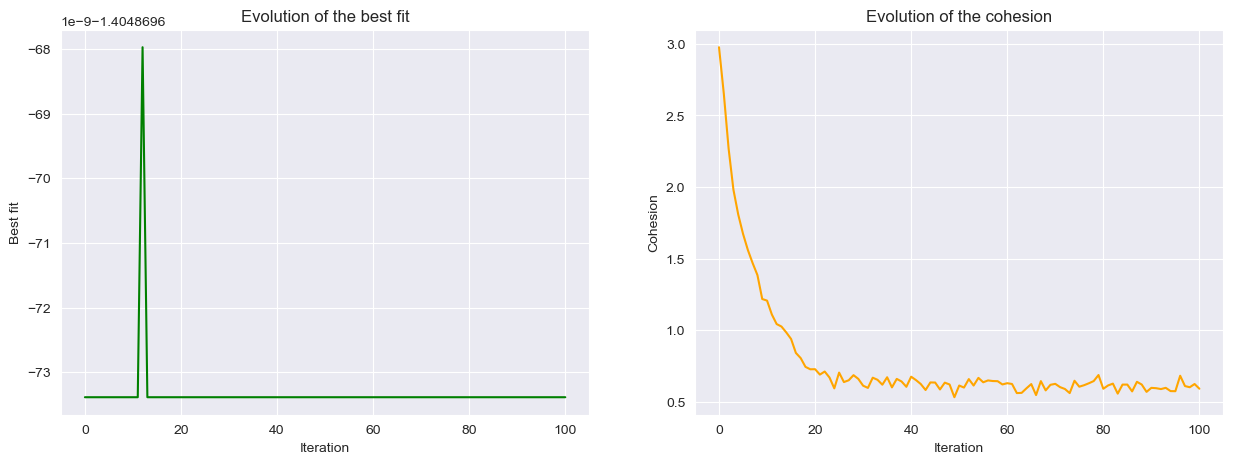

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 12
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.5
 * c1 = 2
 * c2 = 0.25
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


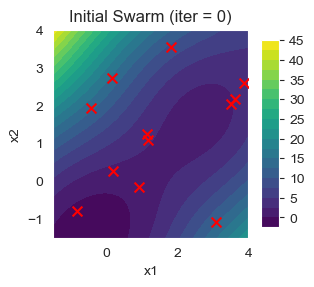

  0%|          | 0/100 [00:00<?, ?it/s]

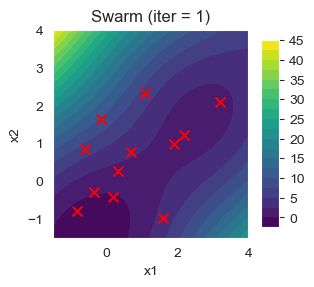

  2%|▏         | 2/100 [00:00<00:20,  4.72it/s]

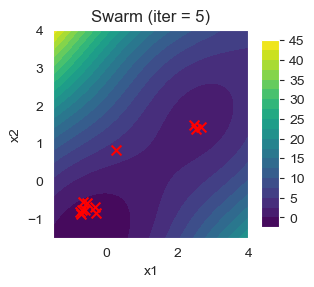

  6%|▌         | 6/100 [00:00<00:12,  7.50it/s]

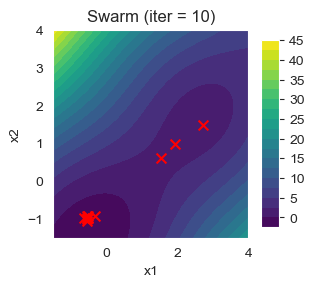

 11%|█         | 11/100 [00:01<00:09,  9.47it/s]

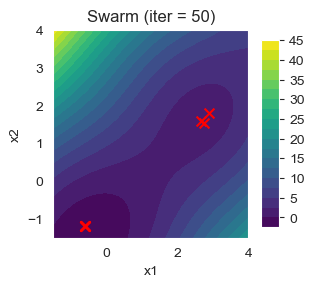

100%|██████████| 100/100 [00:01<00:00, 55.26it/s]


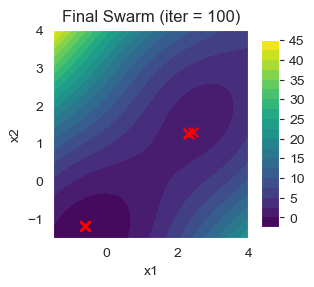

History size :  101
>>> Results after 99 iterations :
> Best solution since the beginning :
  point = [-0.60982547 -1.19193395]
  eval = -1.6996927633055527
> Best solution at the end :
  point = [-0.60982547 -1.19193395]
  eval = -1.6996927633055527
>>> Display history :


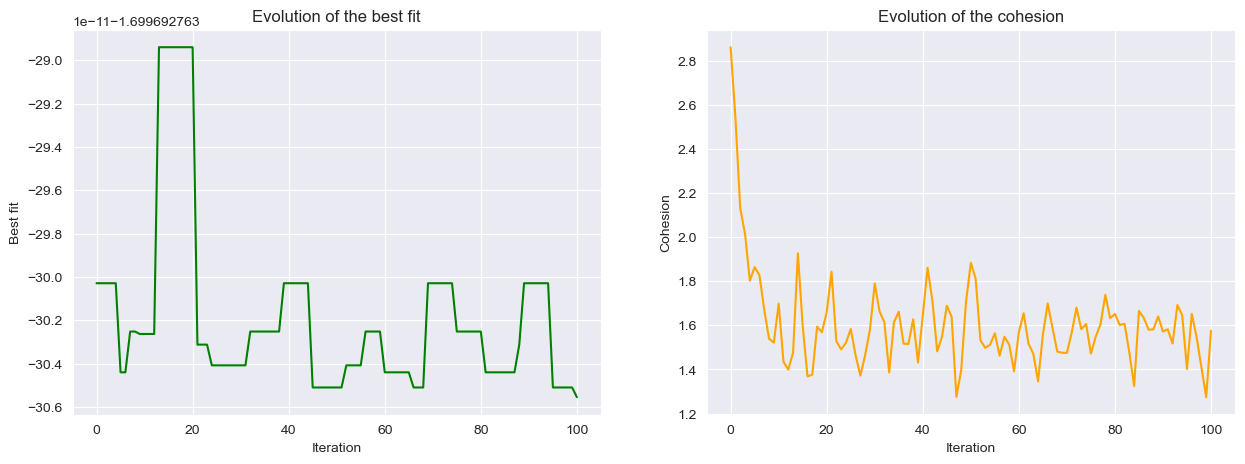

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 50
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.5
 * c1 = 2
 * c2 = 0.25
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


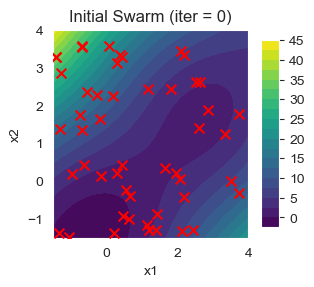

  0%|          | 0/100 [00:00<?, ?it/s]

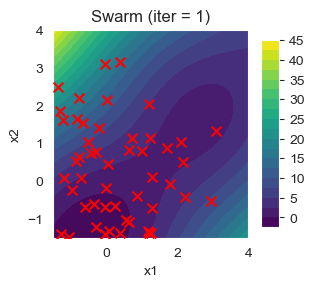

  2%|▏         | 2/100 [00:00<00:25,  3.89it/s]

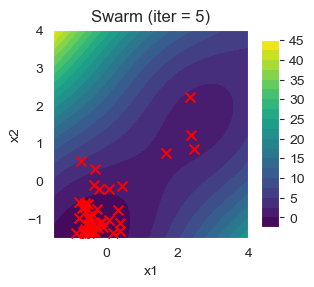

  6%|▌         | 6/100 [00:01<00:19,  4.86it/s]

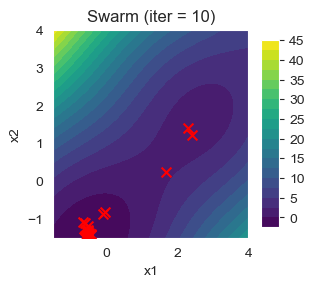

 41%|████      | 41/100 [00:02<00:01, 37.08it/s]

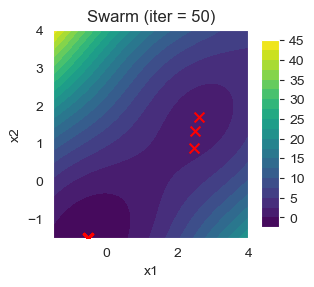

 75%|███████▌  | 75/100 [00:02<00:00, 25.72it/s]


>>> Break : no improvement since 10 iterations


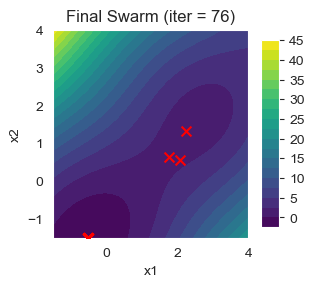

History size :  77
>>> Results after 75 iterations :
> Best solution since the beginning :
  point = [-0.52888339 -1.5       ]
  eval = -1.9105075469843982
> Best solution at the end :
  point = [-0.52888339 -1.5       ]
  eval = -1.9105075469843982
>>> Display history :


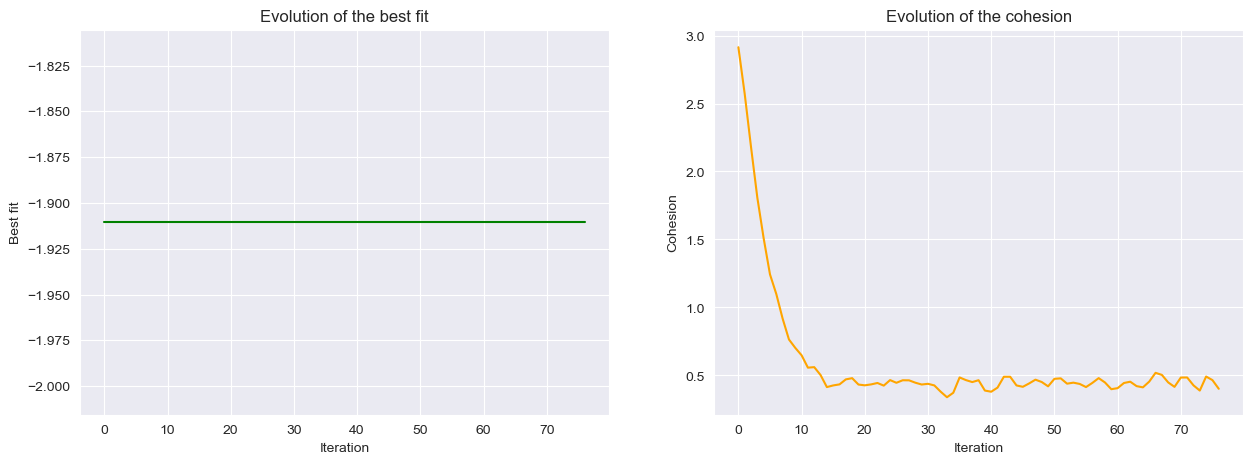

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 12
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.9
 * c1 = 2
 * c2 = 0.25
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


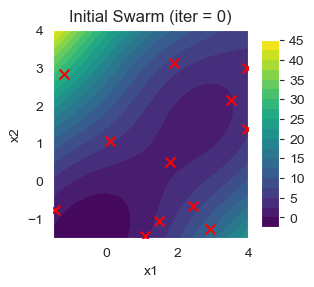

  0%|          | 0/100 [00:00<?, ?it/s]

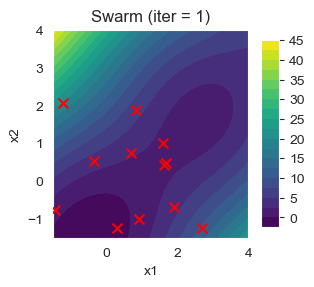

  2%|▏         | 2/100 [00:00<00:20,  4.72it/s]

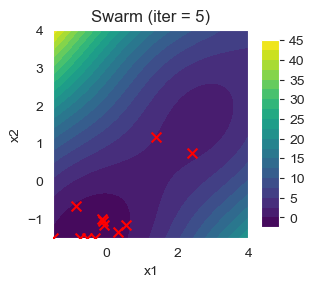

  6%|▌         | 6/100 [00:00<00:12,  7.50it/s]

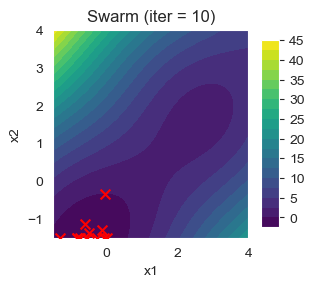

 24%|██▍       | 24/100 [00:01<00:04, 18.66it/s]


>>> Break : no improvement since 10 iterations


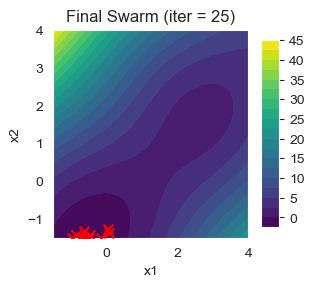

History size :  26
>>> Results after 24 iterations :
> Best solution since the beginning :
  point = [-0.53137963 -1.5       ]
  eval = -1.9104985225627256
> Best solution at the end :
  point = [-0.53137963 -1.5       ]
  eval = -1.9104985225627256
>>> Display history :


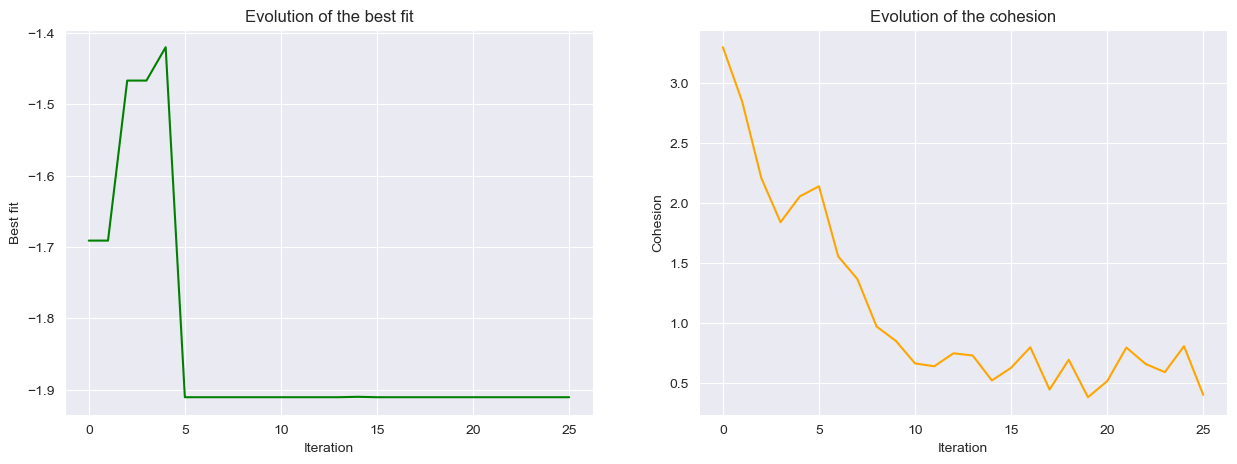

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 50
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.9
 * c1 = 2
 * c2 = 0.25
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


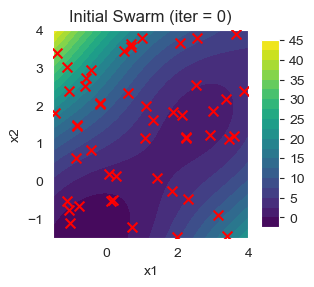

  0%|          | 0/100 [00:00<?, ?it/s]

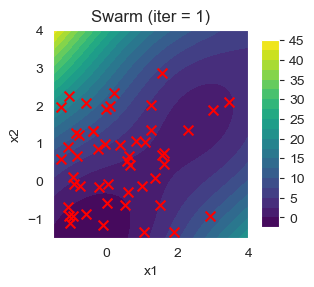

  2%|▏         | 2/100 [00:00<00:25,  3.81it/s]

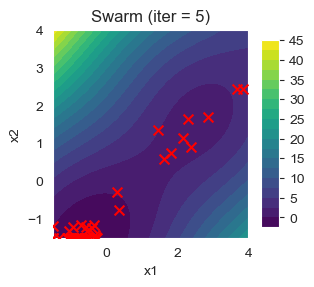

  6%|▌         | 6/100 [00:01<00:15,  6.11it/s]

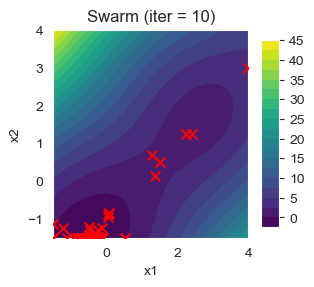

 42%|████▏     | 42/100 [00:01<00:01, 39.67it/s]

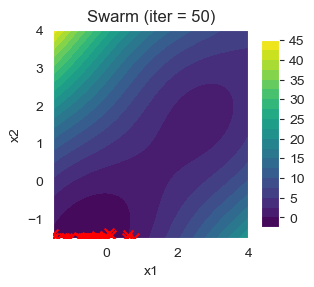

100%|██████████| 100/100 [00:03<00:00, 33.20it/s]


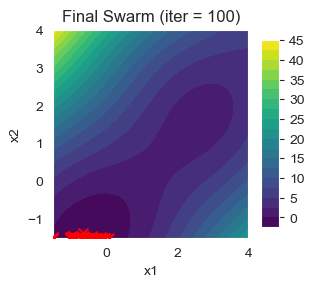

History size :  101
>>> Results after 99 iterations :
> Best solution since the beginning :
  point = [-0.52963779 -1.5       ]
  eval = -1.9105067226972174
> Best solution at the end :
  point = [-0.52963779 -1.5       ]
  eval = -1.9105067226972174
>>> Display history :


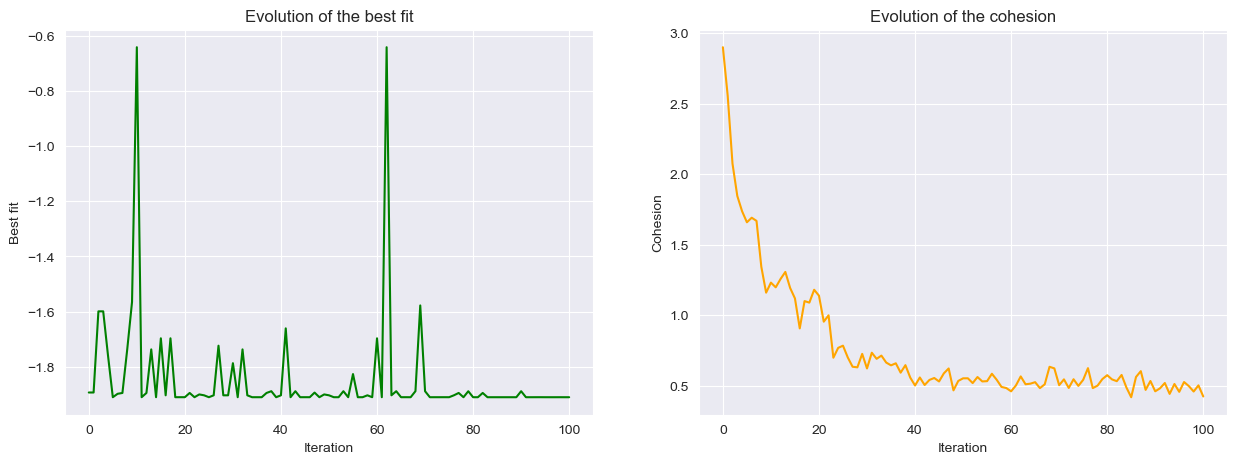

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 12
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.1
 * c1 = 0.25
 * c2 = 0.25
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


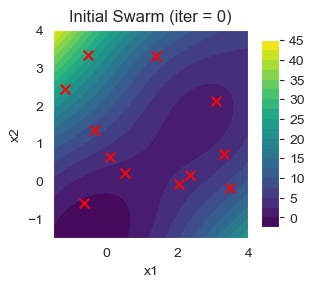

  0%|          | 0/100 [00:00<?, ?it/s]

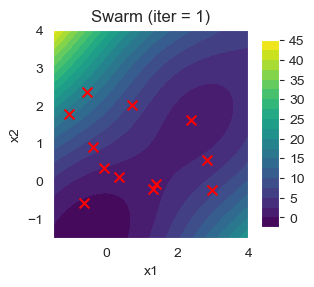

  2%|▏         | 2/100 [00:00<00:21,  4.55it/s]

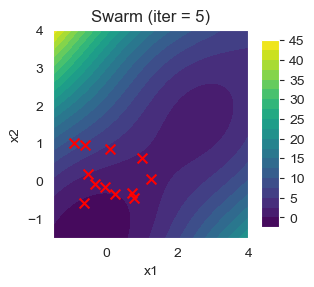

  6%|▌         | 6/100 [00:01<00:16,  5.79it/s]

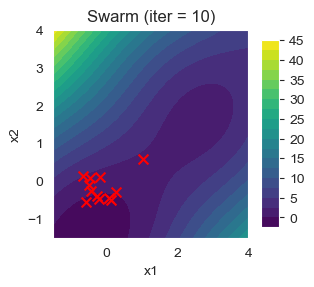

 11%|█         | 11/100 [00:01<00:13,  6.72it/s]

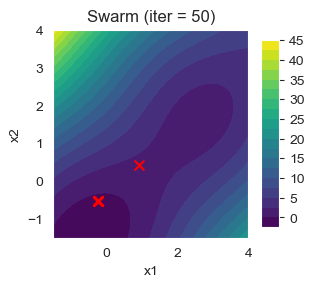

100%|██████████| 100/100 [00:02<00:00, 44.21it/s]


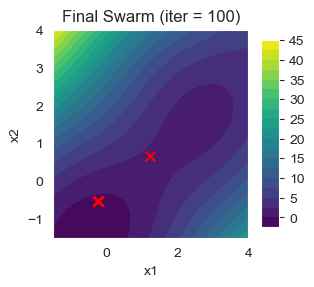

History size :  101
>>> Results after 99 iterations :
> Best solution since the beginning :
  point = [-0.23212816 -0.52006443]
  eval = -0.5523029491889004
> Best solution at the end :
  point = [-0.23212816 -0.52006443]
  eval = -0.5523029491889004
>>> Display history :


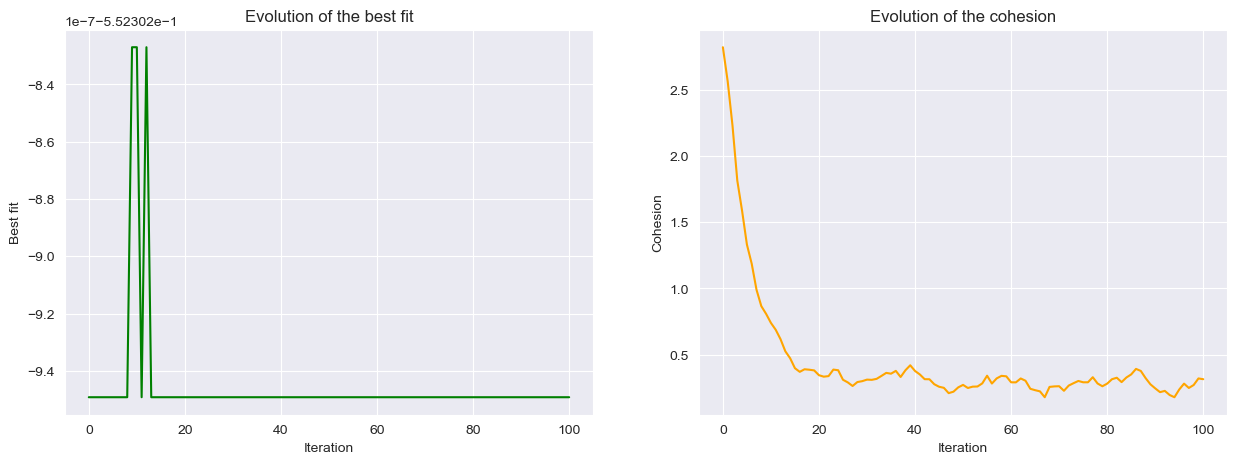

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 50
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.1
 * c1 = 0.25
 * c2 = 0.25
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


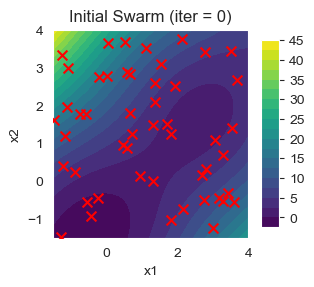

  0%|          | 0/100 [00:00<?, ?it/s]

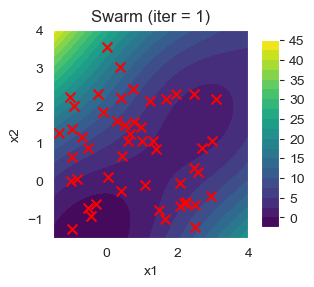

  2%|▏         | 2/100 [00:00<00:34,  2.82it/s]

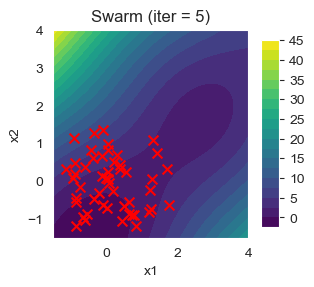

  6%|▌         | 6/100 [00:01<00:18,  5.20it/s]

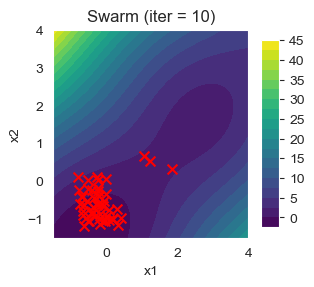

 44%|████▍     | 44/100 [00:02<00:01, 38.42it/s]

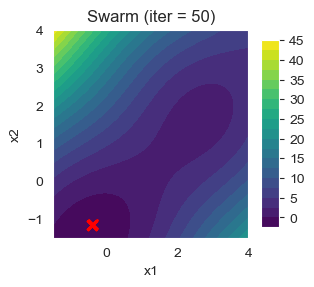

100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


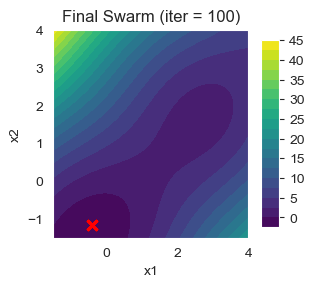

History size :  101
>>> Results after 99 iterations :
> Best solution since the beginning :
  point = [-0.41149001 -1.15916506]
  eval = -1.7216596477372366
> Best solution at the end :
  point = [-0.41149001 -1.15916506]
  eval = -1.7216596477372366
>>> Display history :


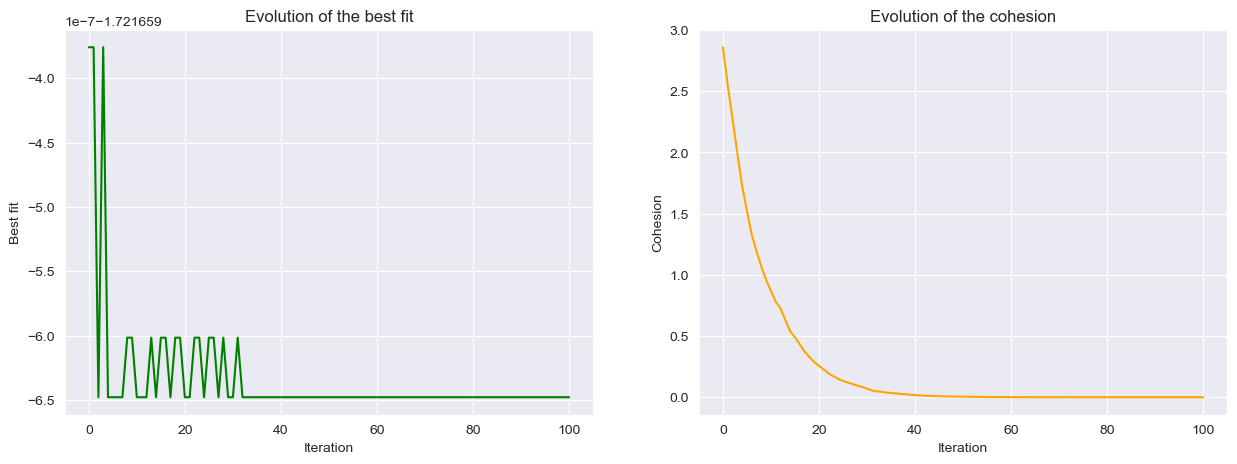

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 12
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.5
 * c1 = 0.25
 * c2 = 0.25
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


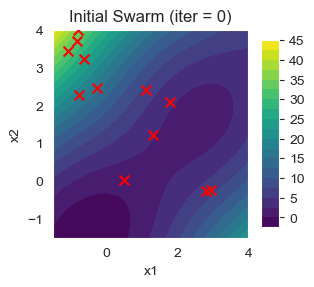

  0%|          | 0/100 [00:00<?, ?it/s]

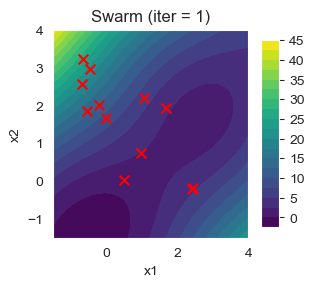

  2%|▏         | 2/100 [00:00<00:21,  4.51it/s]

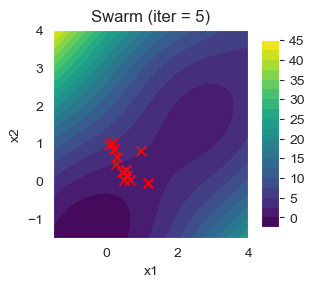

  6%|▌         | 6/100 [00:00<00:13,  7.04it/s]

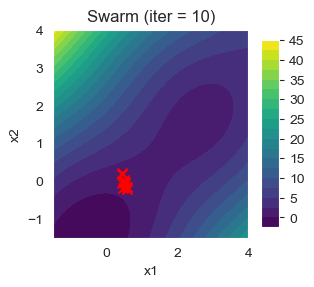

 11%|█         | 11/100 [00:01<00:11,  7.58it/s]

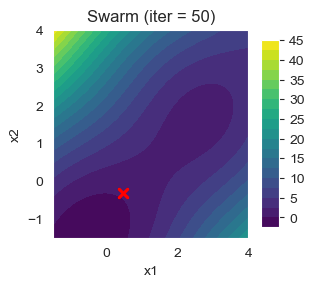

 58%|█████▊    | 58/100 [00:01<00:01, 29.23it/s]


>>> Break : cohesion < epsilon=1e-06


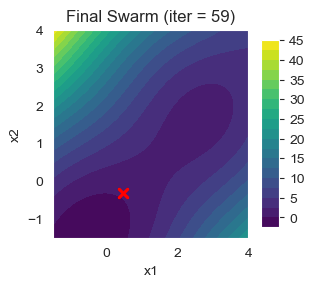

History size :  60
>>> Results after 58 iterations :
> Best solution since the beginning :
  point = [ 0.47787581 -0.30372686]
  eval = 0.30804190064627024
> Best solution at the end :
  point = [ 0.47787581 -0.30372686]
  eval = 0.30804190064627024
>>> Display history :


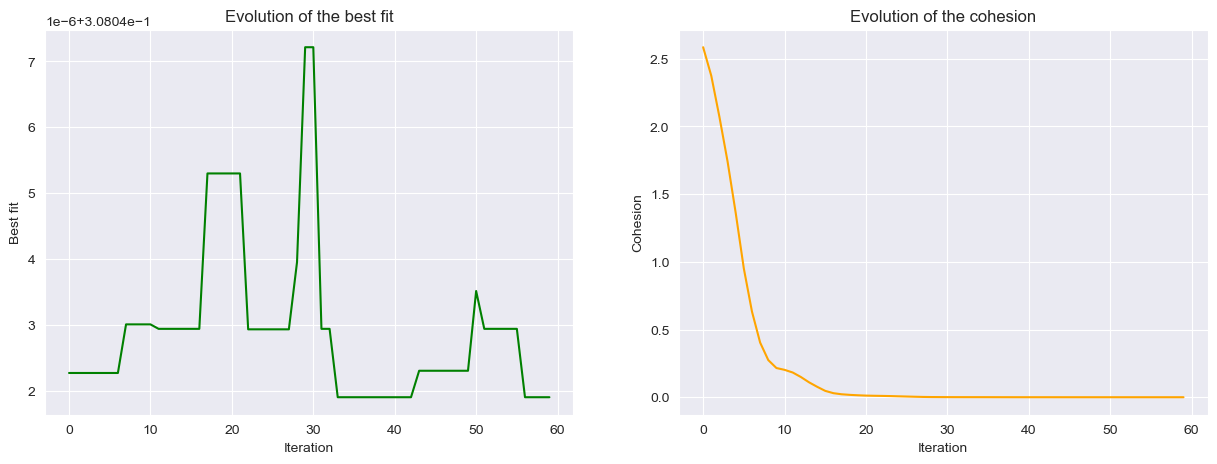

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 50
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.5
 * c1 = 0.25
 * c2 = 0.25
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


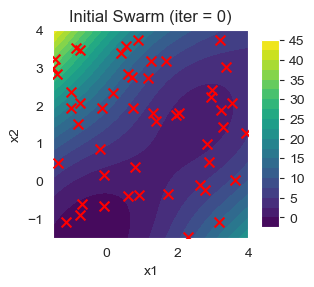

  0%|          | 0/100 [00:00<?, ?it/s]

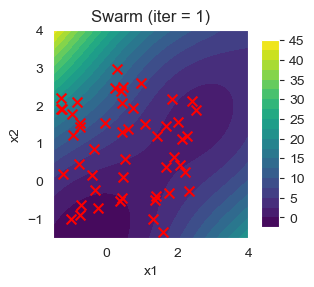

  2%|▏         | 2/100 [00:00<00:25,  3.77it/s]

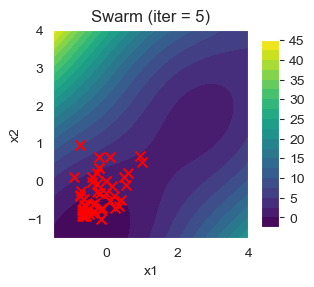

  6%|▌         | 6/100 [00:01<00:15,  5.95it/s]

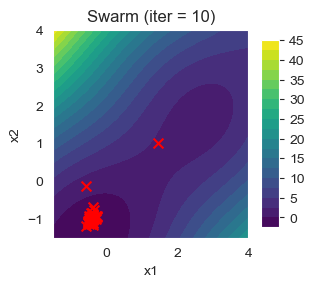

 42%|████▏     | 42/100 [00:01<00:01, 40.92it/s]

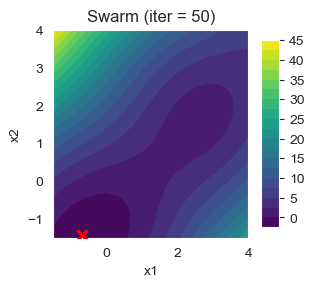

 66%|██████▌   | 66/100 [00:02<00:01, 25.05it/s]


>>> Break : cohesion < epsilon=1e-06


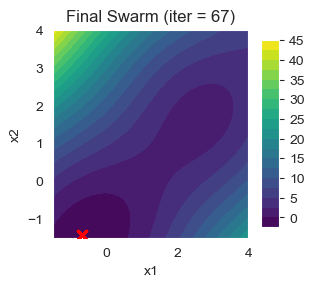

History size :  68
>>> Results after 66 iterations :
> Best solution since the beginning :
  point = [-0.68538026 -1.43285269]
  eval = -1.8492078641892338
> Best solution at the end :
  point = [-0.68538026 -1.43285269]
  eval = -1.8492078641892338
>>> Display history :


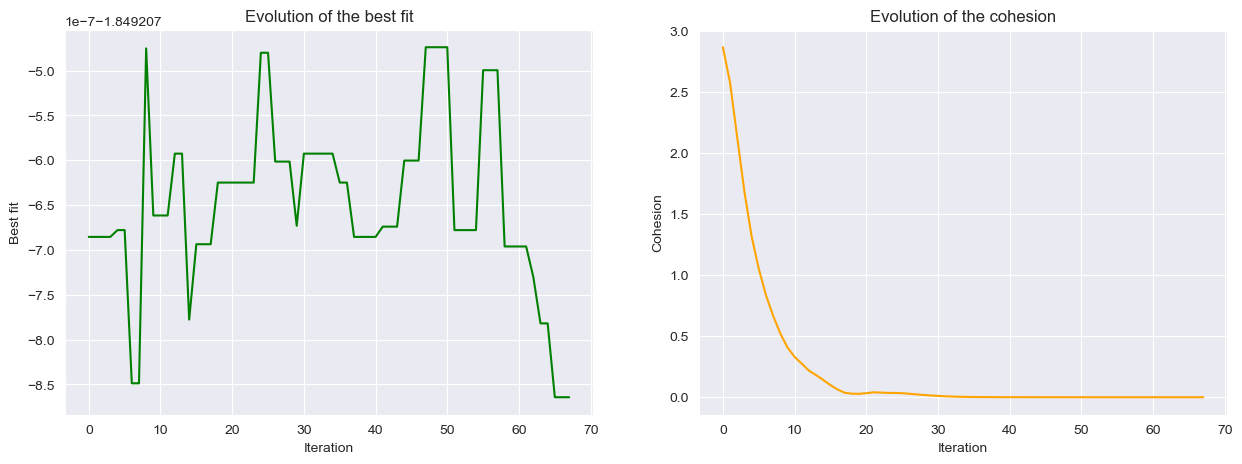

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 12
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.9
 * c1 = 0.25
 * c2 = 0.25
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


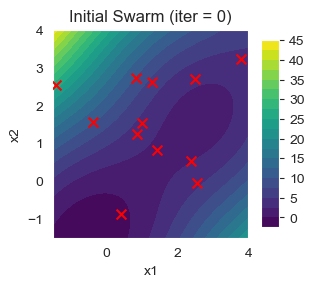

  0%|          | 0/100 [00:00<?, ?it/s]

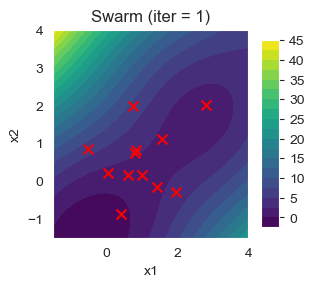

  2%|▏         | 2/100 [00:00<00:24,  4.00it/s]

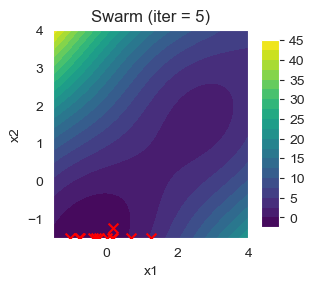

  6%|▌         | 6/100 [00:00<00:14,  6.67it/s]

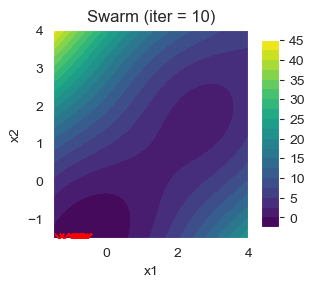

 11%|█         | 11/100 [00:01<00:10,  8.74it/s]

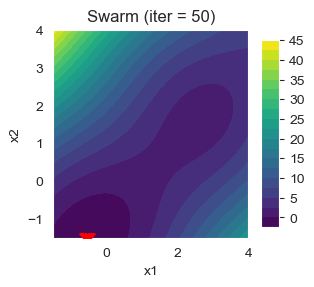

100%|██████████| 100/100 [00:01<00:00, 52.94it/s]


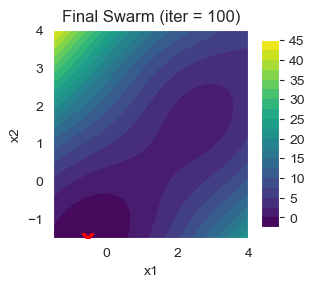

History size :  101
>>> Results after 99 iterations :
> Best solution since the beginning :
  point = [-0.52879901 -1.5       ]
  eval = -1.9105075366702908
> Best solution at the end :
  point = [-0.52879901 -1.5       ]
  eval = -1.9105075366702908
>>> Display history :


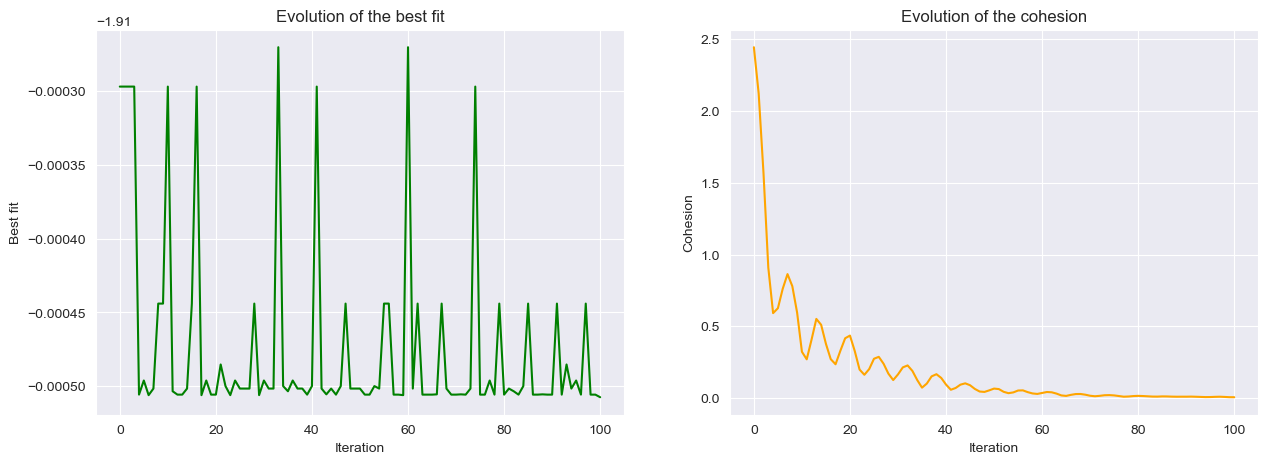

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 50
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.9
 * c1 = 0.25
 * c2 = 0.25
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


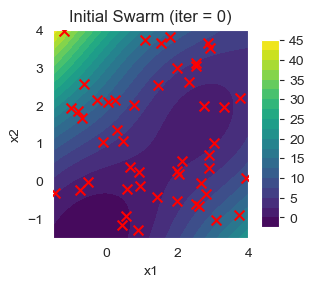

  0%|          | 0/100 [00:00<?, ?it/s]

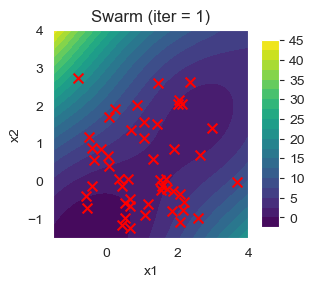

  2%|▏         | 2/100 [00:00<00:26,  3.74it/s]

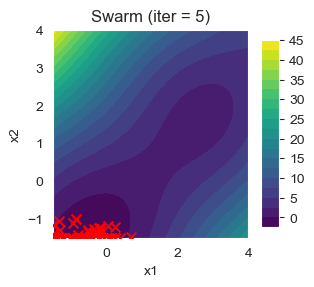

  6%|▌         | 6/100 [00:01<00:16,  5.82it/s]

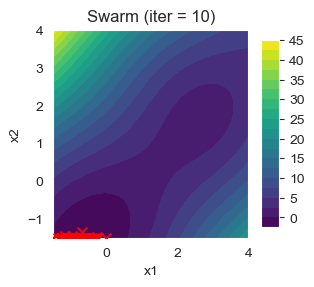

 43%|████▎     | 43/100 [00:01<00:01, 41.05it/s]

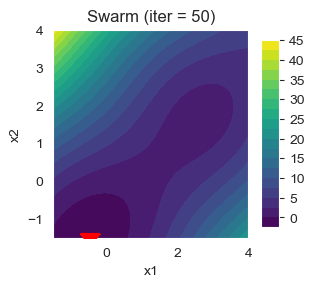

100%|██████████| 100/100 [00:03<00:00, 33.24it/s]


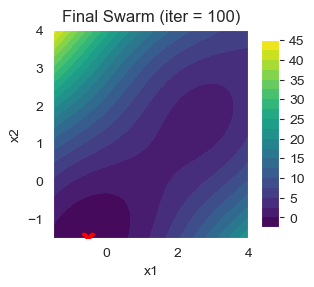

History size :  101
>>> Results after 99 iterations :
> Best solution since the beginning :
  point = [-0.5288698 -1.5      ]
  eval = -1.9105075467165138
> Best solution at the end :
  point = [-0.5288698 -1.5      ]
  eval = -1.9105075467165138
>>> Display history :


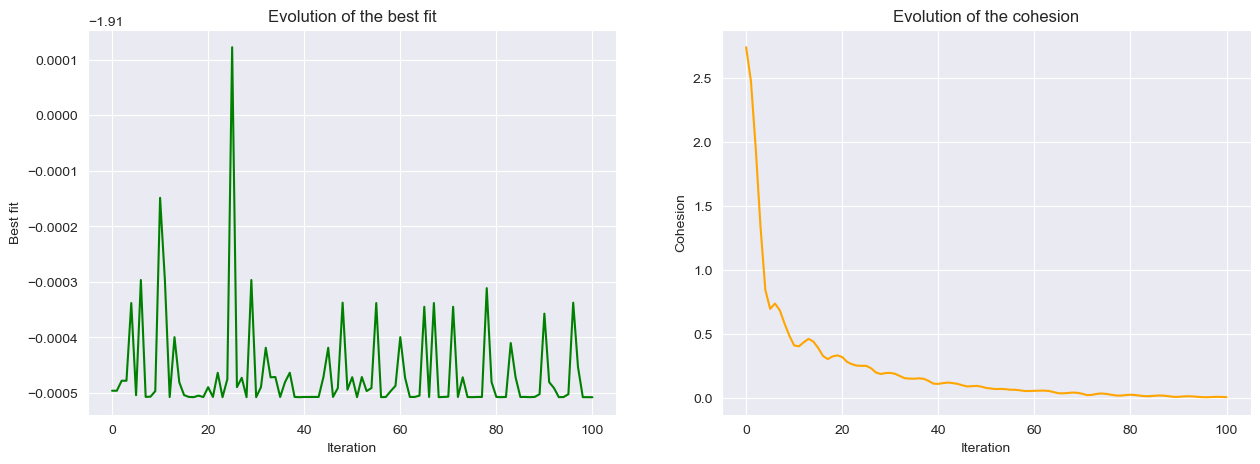

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 12
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.1
 * c1 = 2
 * c2 = 2
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


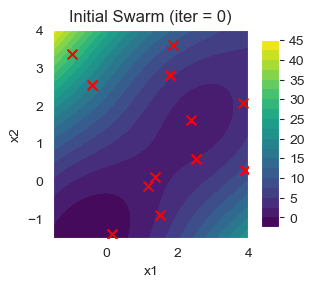

  0%|          | 0/100 [00:00<?, ?it/s]

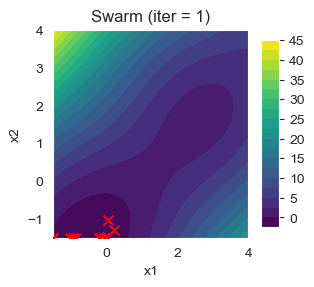

  2%|▏         | 2/100 [00:00<00:23,  4.15it/s]

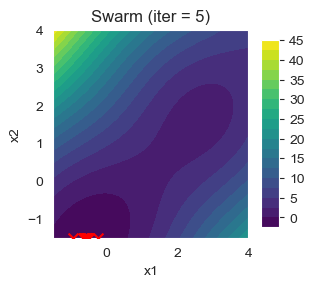

  6%|▌         | 6/100 [00:01<00:17,  5.28it/s]

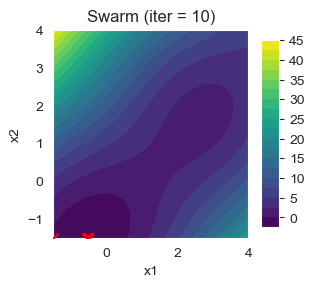

 34%|███▍      | 34/100 [00:01<00:03, 20.64it/s]


>>> Break : no improvement since 10 iterations


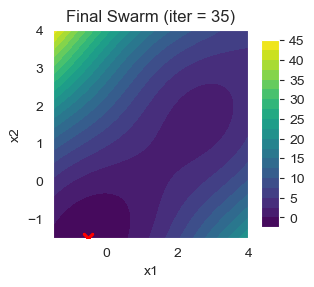

History size :  36
>>> Results after 34 iterations :
> Best solution since the beginning :
  point = [-0.5288834 -1.5      ]
  eval = -1.9105075469843982
> Best solution at the end :
  point = [-0.5288834 -1.5      ]
  eval = -1.9105075469843982
>>> Display history :


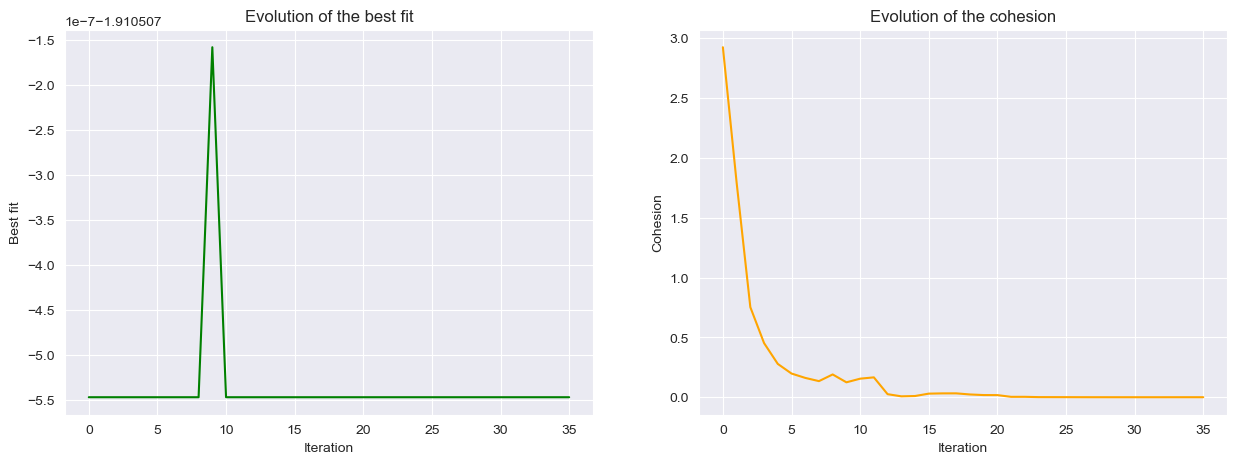

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 50
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.1
 * c1 = 2
 * c2 = 2
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


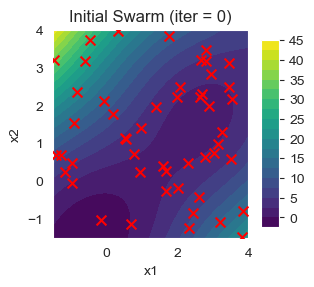

  0%|          | 0/100 [00:00<?, ?it/s]

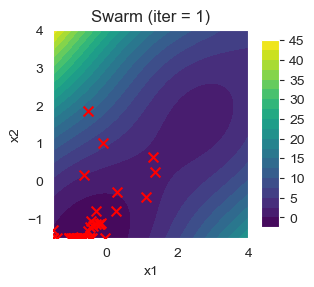

  2%|▏         | 2/100 [00:00<00:26,  3.66it/s]

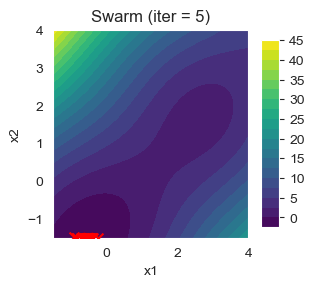

  6%|▌         | 6/100 [00:01<00:15,  5.92it/s]

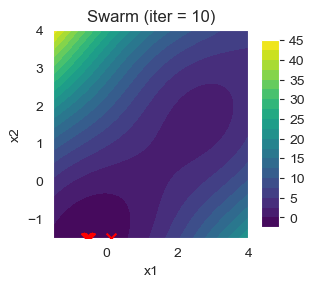

 35%|███▌      | 35/100 [00:01<00:03, 18.75it/s]


>>> Break : no improvement since 10 iterations


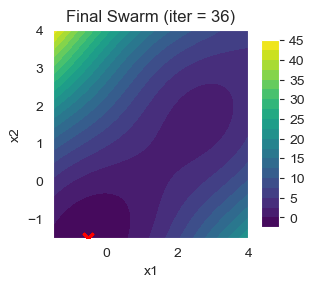

History size :  37
>>> Results after 35 iterations :
> Best solution since the beginning :
  point = [-0.52888339 -1.5       ]
  eval = -1.9105075469843982
> Best solution at the end :
  point = [-0.52888339 -1.5       ]
  eval = -1.9105075469843982
>>> Display history :


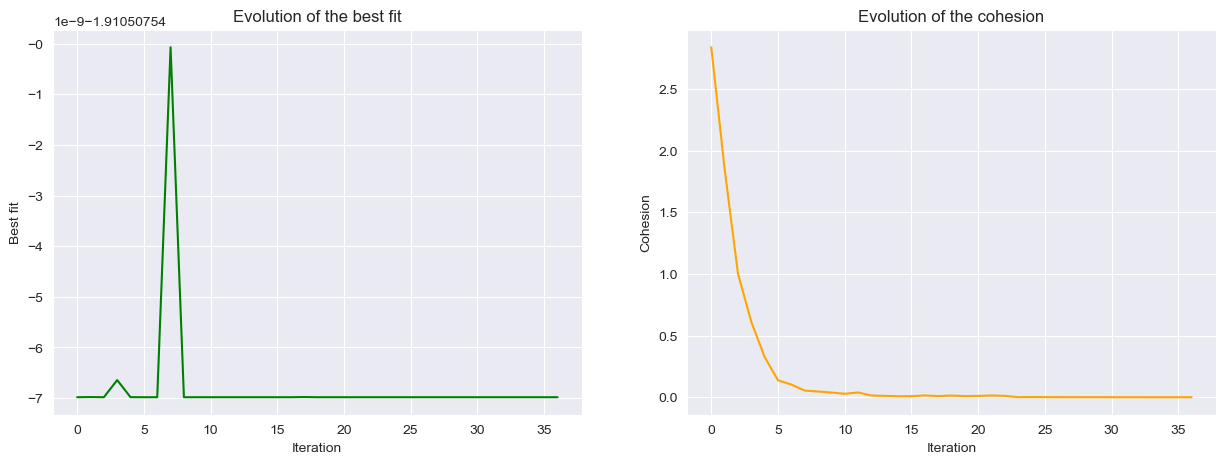

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 12
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.5
 * c1 = 2
 * c2 = 2
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


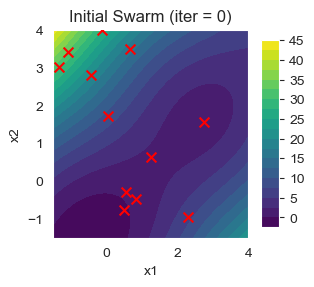

  0%|          | 0/100 [00:00<?, ?it/s]

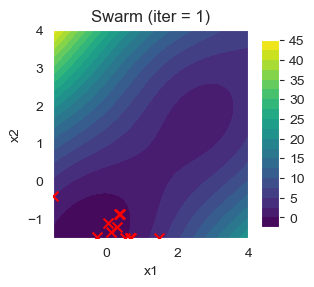

  2%|▏         | 2/100 [00:00<00:21,  4.56it/s]

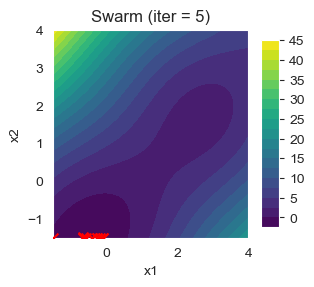

  6%|▌         | 6/100 [00:00<00:12,  7.49it/s]

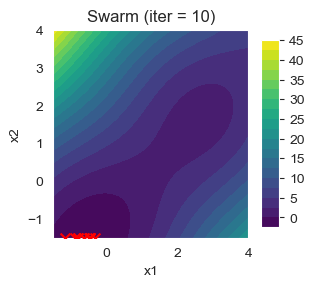

 48%|████▊     | 48/100 [00:01<00:01, 36.05it/s]


>>> Break : no improvement since 10 iterations


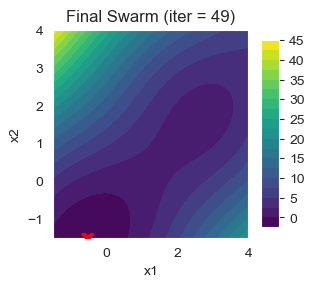

History size :  50
>>> Results after 48 iterations :
> Best solution since the beginning :
  point = [-0.5288735 -1.5      ]
  eval = -1.91050754684264
> Best solution at the end :
  point = [-0.5288735 -1.5      ]
  eval = -1.91050754684264
>>> Display history :


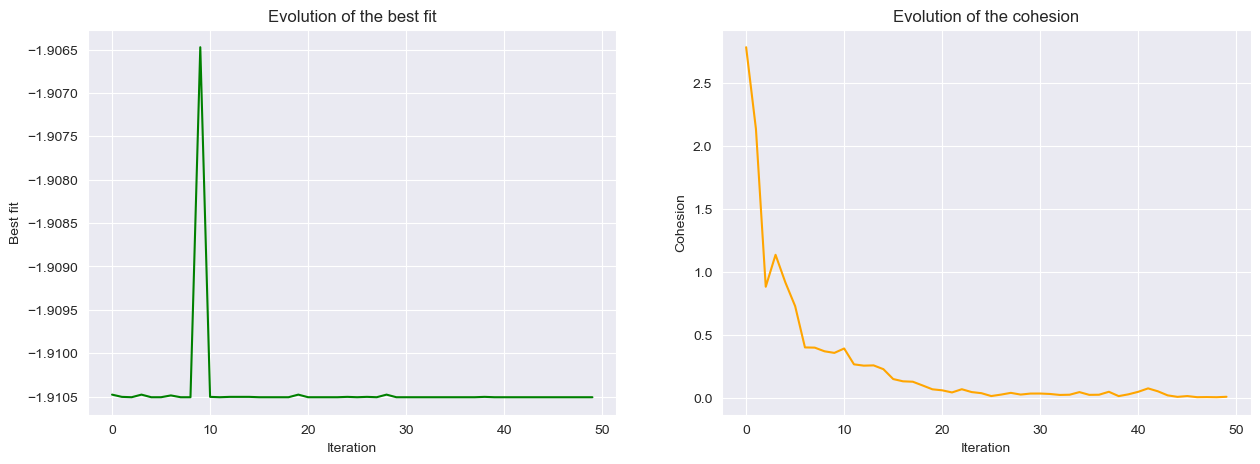

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 50
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.5
 * c1 = 2
 * c2 = 2
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


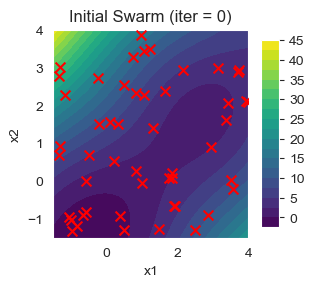

  0%|          | 0/100 [00:00<?, ?it/s]

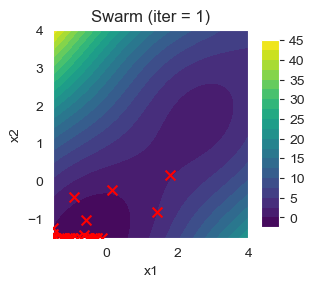

  2%|▏         | 2/100 [00:00<00:27,  3.61it/s]

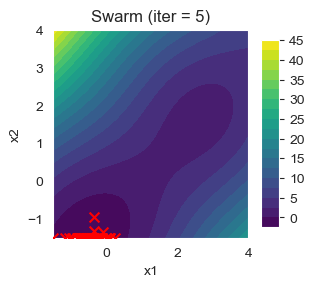

  6%|▌         | 6/100 [00:01<00:23,  3.99it/s]

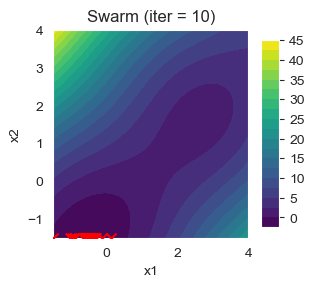

 42%|████▏     | 42/100 [00:02<00:01, 33.50it/s]

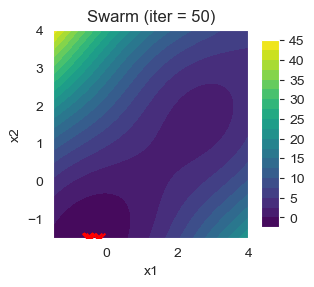

 86%|████████▌ | 86/100 [00:03<00:00, 25.09it/s]


>>> Break : no improvement since 10 iterations


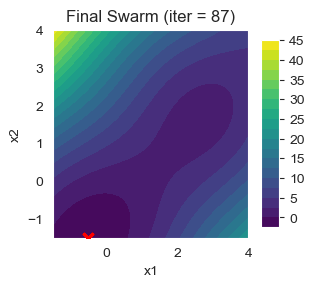

History size :  88
>>> Results after 86 iterations :
> Best solution since the beginning :
  point = [-0.52888339 -1.5       ]
  eval = -1.9105075469843982
> Best solution at the end :
  point = [-0.52888339 -1.5       ]
  eval = -1.9105075469843982
>>> Display history :


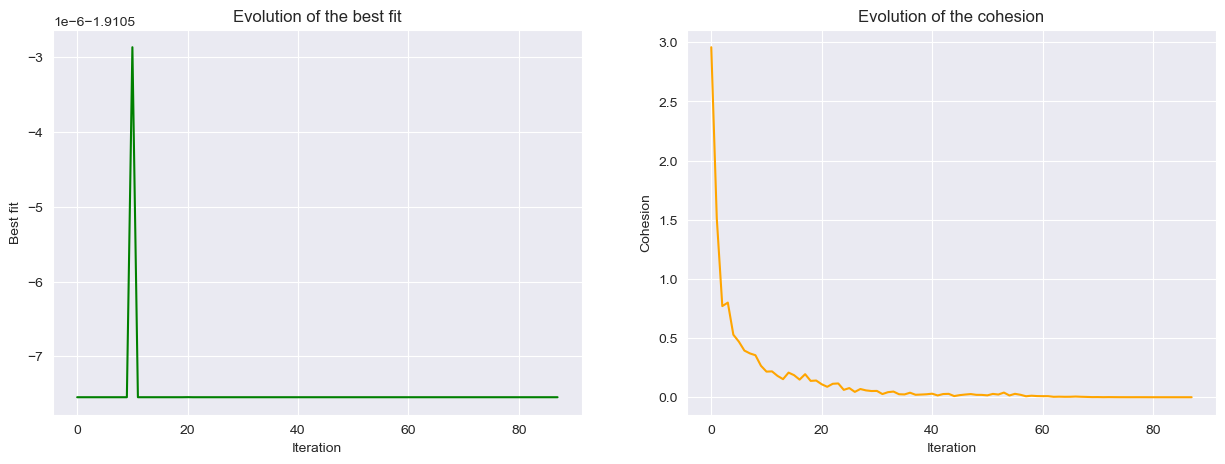

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 12
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.9
 * c1 = 2
 * c2 = 2
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


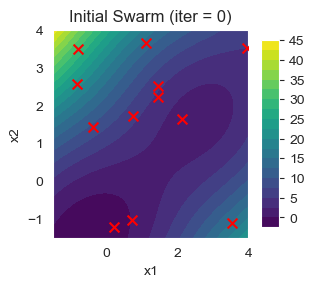

  0%|          | 0/100 [00:00<?, ?it/s]

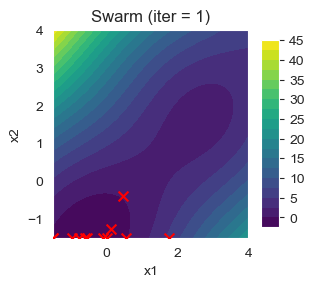

  2%|▏         | 2/100 [00:00<00:22,  4.33it/s]

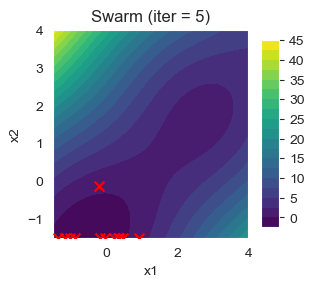

  6%|▌         | 6/100 [00:00<00:13,  7.19it/s]

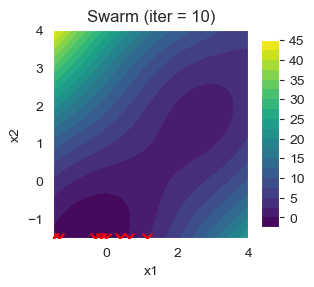

 11%|█         | 11/100 [00:01<00:11,  7.53it/s]

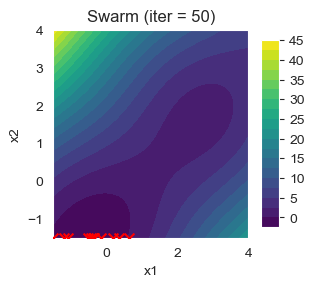

 92%|█████████▏| 92/100 [00:02<00:00, 45.65it/s]


>>> Break : no improvement since 10 iterations


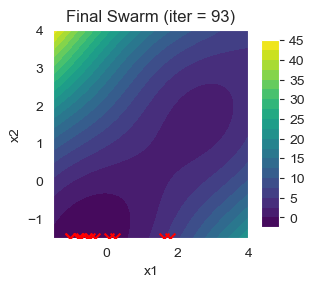

History size :  94
>>> Results after 92 iterations :
> Best solution since the beginning :
  point = [-0.53625967 -1.5       ]
  eval = -1.9104287673770193
> Best solution at the end :
  point = [-0.53625967 -1.5       ]
  eval = -1.9104287673770193
>>> Display history :


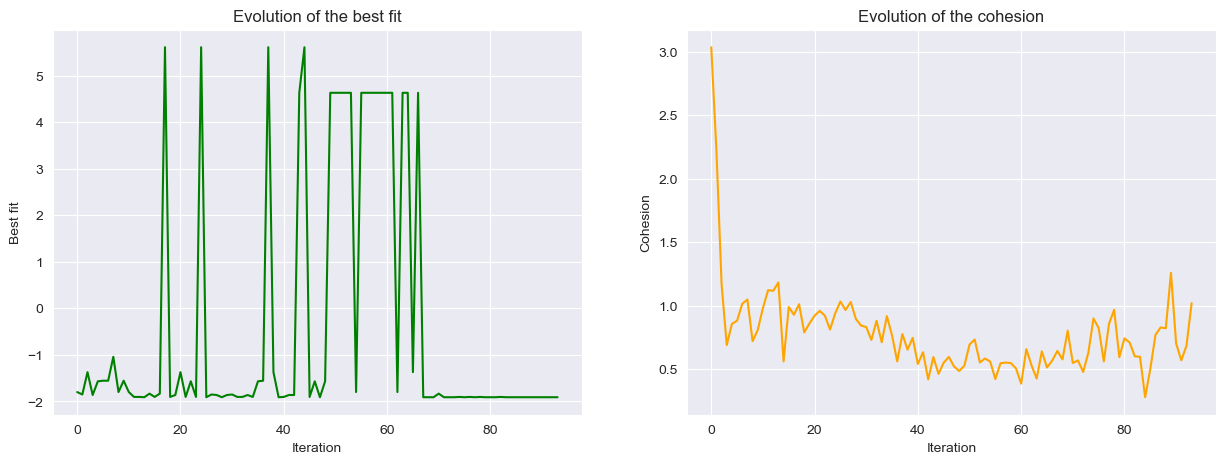

######################################################################
>>> Start PSO algorithm
>>> Parameters :
 * n_particles = 50
 * iter_max = 100
 * dim = 2
 * eval_func = mccormick
 * psi = 0.9
 * c1 = 2
 * c2 = 2
 * epsilon_coherence = 1e-06
 * max_iter_no_improvement = 10


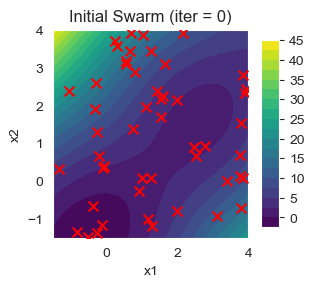

  0%|          | 0/100 [00:00<?, ?it/s]

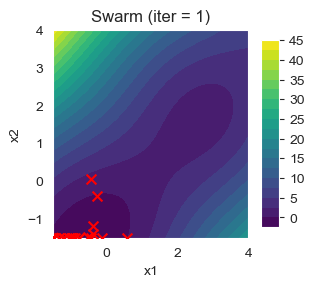

  2%|▏         | 2/100 [00:00<00:25,  3.83it/s]

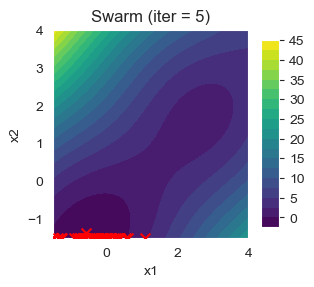

  6%|▌         | 6/100 [00:01<00:15,  5.95it/s]

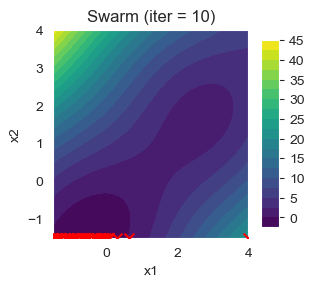

 48%|████▊     | 48/100 [00:02<00:01, 46.50it/s]

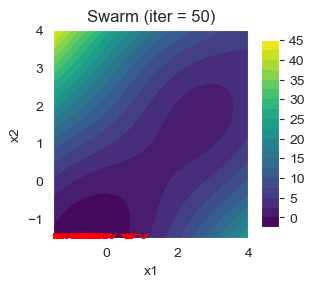

 54%|█████▍    | 54/100 [00:02<00:02, 20.33it/s]

>>> Break : no improvement since 10 iterations


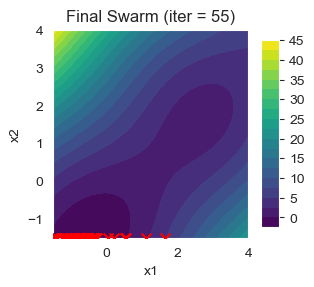

History size :  56
>>> Results after 54 iterations :
> Best solution since the beginning :
  point = [-0.5301931 -1.5      ]
  eval = -1.910505062597101
> Best solution at the end :
  point = [-0.5301931 -1.5      ]
  eval = -1.910505062597101
>>> Display history :


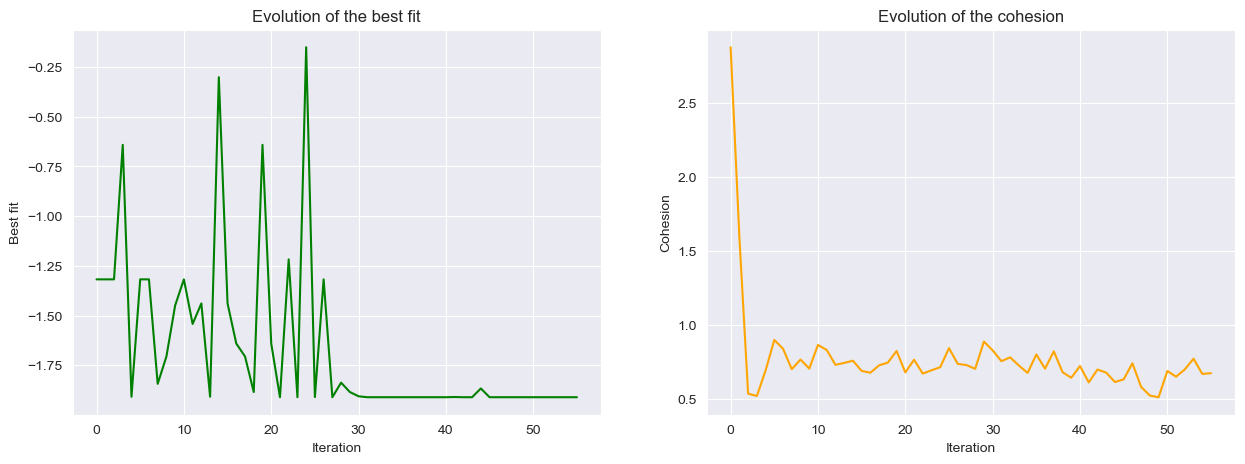

In [44]:
for c1, c2 in [(0.25, 2), (2, 0.25), (0.25, 0.25), (2, 2)]:
    for psi in [0.1, 0.5, 0.9]:
        for n_particles in [int(10 + 2 * np.sqrt(DIM)), 50]:
            print("#" * 70)
            best_since_beginning, _, _, _, _ = pso_algorithm_continu(
                n_particles=n_particles, iter_max=100,
                dim=DIM, infs=INFS, sups=SUPS,
                eval_func=FUNCTION,
                psi=psi, c1=c1, c2=c2, iter_swarm_plots=[1, 5, 10, 50], max_iter_no_improvement=10)


### with same parameters


In [52]:

def pso_algorithm_continu_n_runs(n_runs: int, n_particles: int, iter_max: int, dim: int, infs: list, sups: list,
                                 eval_func, psi: float = PSI, c1: float = C1, c2: float = C2,
                                 epsilon_coherence: float = 1e-06, max_iter_no_improvement: int = 15):
    solutions_outputs = []
    for _ in tqdm(range(n_runs)):
        best_since_beginning, _, _, _,_ = pso_algorithm_continu(
            n_particles=n_particles, iter_max=iter_max,
            dim=dim, infs=infs, sups=sups,
            eval_func=eval_func,
            psi=psi, c1=c1, c2=c2, verbose=False, display_history=False, display_swarm_plots=False,
            epsilon_coherence=epsilon_coherence, max_iter_no_improvement=max_iter_no_improvement)
        solutions_outputs.append(
            best_since_beginning)  # on enregistre la meilleure solution depuis le debut de l'execution

    return solutions_outputs, get_best_particles(solutions_outputs)


N_RUNS = 50
solutions_outputs, best_solution_after_n_runs = pso_algorithm_continu_n_runs(n_runs=N_RUNS, n_particles=N_PARTICLES,
                                                                             iter_max=ITER_MAX, dim=DIM, infs=INFS,
                                                                             sups=SUPS,
                                                                             eval_func=FUNCTION,
                                                                             max_iter_no_improvement=10,
                                                                             psi=PSI, c1=C1, c2=C2)

100%|██████████| 50/50 [00:07<00:00,  6.66it/s]


#### Display results

In [53]:
print_solution(best_solution_after_n_runs)

  point = [-0.52888339 -1.5       ]
  eval = -1.9105075469843982


In [54]:
solutions_outputs_fit = np.array([sol["fit"] for sol in solutions_outputs])

print("Count: %d \nMean: %.1f \nStd: %.1f \nMin: %.1f \nMax: %.1f" % (
    len(solutions_outputs_fit), solutions_outputs_fit.mean(), solutions_outputs_fit.std(), solutions_outputs_fit.min(),
    solutions_outputs_fit.max()))

print()
median, q1, q3 = np.percentile(solutions_outputs_fit, [50, 25, 75])
print("Median: %.1f \nQ1: %.1f \nQ3: %.1f" % (median, q1, q3))

Count: 50 
Mean: -1.6 
Std: 0.9 
Min: -1.9 
Max: 1.2

Median: -1.9 
Q1: -1.9 
Q3: -1.9


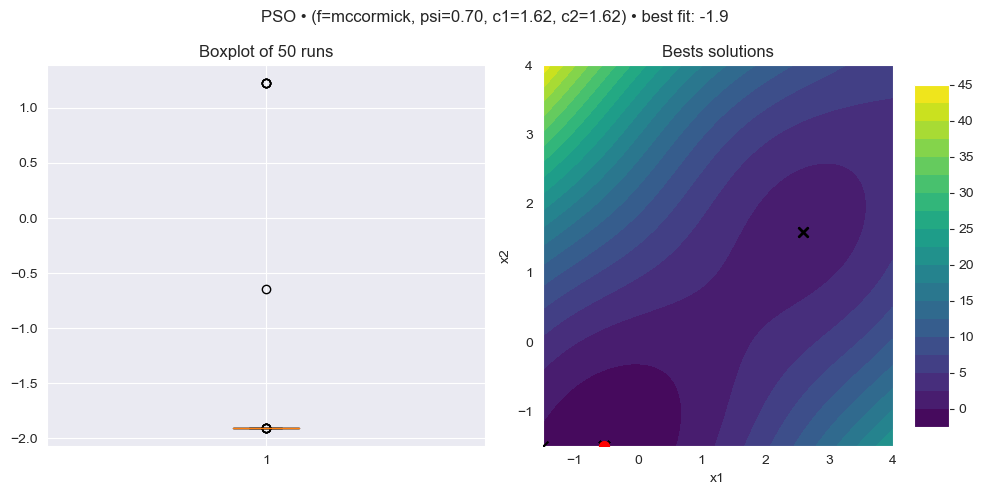

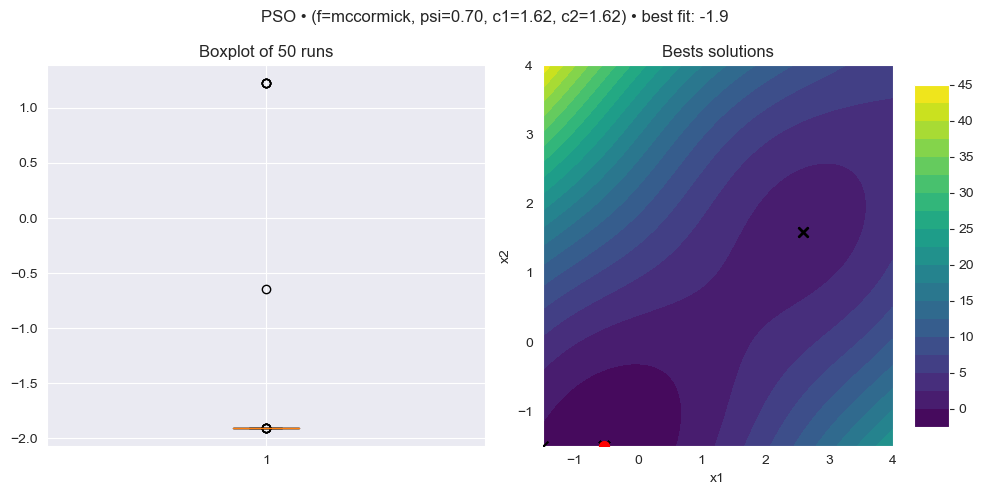

In [60]:
def plot_results_after_n_runs(solutions_outputs, best_solution_after_n_runs, n_runs, dim: int, infs: list, sups: list,
                              eval_func, iter_max: int, n_particles: int, psi: float, c1: float, c2: float,
                              bool_show: bool = True, save_fig: bool = False):
    solutions_outputs_fit = np.array([sol["fit"] for sol in solutions_outputs])
    if dim != 2:
        fig_result, (ax1, ax2) = plt.subplots(1, 1, tight_layout=True, figsize=(5, 5))
        title = f'PSO • (f=%s, psi=%.2f, c1=%.2f, c2=%.2f) • best fit: %.2f' % (eval_func.__name__, psi, c1, c2, best_solution_after_n_runs["fit"])
        fig_result.suptitle(title)

        ax1.set_title(f"Boxplot of {n_runs} runs")
        ax1.boxplot(solutions_outputs_fit)
    else:

        fig_result, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
        title = f'PSO • (f=%s, psi=%.2f, c1=%.2f, c2=%.2f) • best fit: %.2f' % (
            eval_func.__name__, psi, c1, c2, best_solution_after_n_runs["fit"])
        fig_result.suptitle(title)

        ax1.set_title(f"Boxplot of {n_runs} runs")
        ax1.boxplot(solutions_outputs_fit)

        # plot function
        x = np.linspace(infs[0], sups[0], 100)
        y = np.linspace(infs[1], sups[1], 100)
        X, Y = np.meshgrid(x, y)
        Z = eval_func(np.array([X, Y]))
        ax2.contour(X, Y, Z, 20, cmap='viridis', zorder=0)
        # add range bar on the right
        fig_result.colorbar(ax2.contourf(X, Y, Z, 20, cmap='viridis'), ax=ax2, shrink=0.9, aspect=10)
        # Plot the swarm (top view)
        ax2.set_xlim(infs[0], sups[0])
        ax2.set_ylim(infs[1], sups[1])
        ax2.set_xlabel("x1")
        ax2.set_ylabel("x2")
        ax2.set_title("Bests solutions")
        # Plot the swarm
        for particle in solutions_outputs:
            ax2.scatter(particle["pos"][0], particle["pos"][1], color="black", s=50, zorder=10, marker="x")

        # plot best solution in red
        ax2.scatter(best_solution_after_n_runs["pos"][0], best_solution_after_n_runs["pos"][1], color="red", s=50,
                    zorder=10, marker="o")

    if save_fig:
        fig_name = "%s (method=%s, dim=%d, nb_particles=%d, psi=%.2f, c1=%.2f, c2=%.2f, iter_max=%d, n_runs=%d) bestfit=%.2f.png" % (
            eval_func.__name__, "PSO", dim, n_particles, psi, c1, c2, iter_max, n_runs, best_solution_after_n_runs["fit"])
        fig_result.savefig("plots/" + fig_name)
    if bool_show:
        plt.show()


plot_results_after_n_runs(solutions_outputs, best_solution_after_n_runs, n_runs=N_RUNS, n_particles=N_PARTICLES,
                          iter_max=ITER_MAX, dim=DIM, infs=INFS, sups=SUPS,
                          eval_func=FUNCTION, psi=PSI, c1=C1, c2=C2, save_fig=True)

## Ressources & Notes

- https://www.youtube.com/watch?v=JhgDMAm-imI
- https://towardsdatascience.com/particle-swarm-optimization-visually-explained-46289eeb2e14

---

> *inertia*, *cognitive* and *social coefficients*.

These coefficients control the levels of exploration and exploitation.

* **Exploitation** is the ability of particles to target the best solutions found so far.
* **Exploration**, on the other hand, is the ability of particles to evaluate the entire research space.

The challenge will be to determine the impact of these coefficients to find a good balance between exploration and exploitation.